# 0. Import libraries

In [35]:
# ================== Core Libraries ==================
import os
import json
import warnings
import joblib

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# ================== Visualization ==================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# ================== Statistical Analysis ==================
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.interpolate import RBFInterpolator
from scipy.spatial import KDTree

from statsmodels.stats.outliers_influence import variance_inflation_factor

# ================== Machine Learning ==================
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, silhouette_score
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.inspection import PartialDependenceDisplay
import shap
from pdpbox import pdp

# ================== Optimization and Pareto Analysis ==================
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# ================== Geospatial Analysis ==================
import geopandas as gpd
import fiona
import pyogrio
import rasterio
from rasterstats import zonal_stats

# ================== Pandas Display Settings ==================
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_columns", None)

# ================== Matplotlib Settings ==================
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False

# ================== Notebook Settings ==================
# Only required when running in Jupyter
%matplotlib inline

# 1. Data preprocessing

In [11]:
df = pd.read_csv('../data/grid500_36cities.csv')
grid500 = df.copy()
print(grid500.shape)
grid500.head()

(196770, 47)


Global_ID     City  NTL2023  NTL2023_focal  VIT202311  UHIDAY2020_07_inv  \
0          0  Beijing     6.18           7.03    1649.86               0.00   
1          1  Beijing     5.74           7.23     155.86               0.00   
2          2  Beijing    11.32          13.62      57.14               0.00   
3          3  Beijing    11.73          14.36     243.57               0.00   
4          4  Beijing     8.45           9.19       0.00               0.00   

   buildingCount  totalHeight  avgHeight  maxHeight  minHeight  heightRange  \
0             31        93.00       3.00       3.00       3.00         0.00   
1             29        87.00       3.00       3.00       3.00         0.00   
2             22        66.00       3.00       3.00       3.00         0.00   
3              8        24.00       3.00       3.00       3.00         0.00   
4              0         0.00       0.00       0.00       0.00         0.00   

   heightIndex  heightDensity  heightOtherness  cornerCountTotal  \
0         0.03           0.00             0.00               180   
1         0.03           0.00             0.00               149   
2         0.05           0.00             0.00               117   
3         0.12           0.00             0.00                42   
4         0.00           0.00             0.00                 0   

   basePerimeterTotal  basePerimeterAvg  basePerimeterMax  basePerimeterMin  \
0             6500.98            209.71            831.63             32.55   
1             3810.39            131.39            272.14             15.33   
2             3645.40            165.70            668.26             28.73   
3             1147.60            143.45            283.01             75.66   
4                0.00              0.00              0.00              0.00   

   shapeComplexity  compactness  footprintAreaTotal  totalArea  areaVariance  \
0             5.07         0.56            88704.58   88704.58   50961857.70   
1             5.17         0.62            33119.49   33119.49    1261729.88   
2             4.92         0.56            51092.86   51092.86   30358745.83   
3             5.70         0.60             8534.61    8534.61     958399.89   
4             0.00         0.00                0.00       0.00          0.00   

   avgBuildingArea  parcelArea  largestPatchIndex  shape3DIndex  SVF  \
0          2861.44   132998.25               0.47          0.01 0.80   
1          1142.05   196625.22               0.67          0.26 0.89   
2          2322.40   132197.31               0.53          0.01 0.90   
3          1066.83   205685.37               0.82          0.02 0.95   
4             0.00       99.15               0.00          0.00 0.98   

   evennessIndex  FAR  coverageRatio  FVC  permeableRatio  poiDensity  \
0         234.60 0.35           0.35 0.84            0.89        4.00   
1          35.66 0.13           0.13 0.86            0.94       12.00   
2         151.50 0.20           0.20 0.88            0.93        0.00   
3          15.54 0.03           0.03 0.93            0.98        0.00   
4           0.00 0.00           0.00 0.82            0.98       16.00   

   poiDiversity  streetRatio  roadDensity  intersectionDensity  \
0          0.00         0.20            5                    1   
1          0.64         0.20            7                    1   
2          0.00         0.20            1                    0   
3          0.00         0.20            3                    1   
4          0.69         0.00            1                    1   

   cornerCountAvg  buildingProximity  buildingMinDist  buildingMaxDist  \
0            5.81              52.56            14.99           620.94   
1            5.14              34.22             6.82           594.16   
2            5.32              47.90            17.34           610.84   
3            5.25              35.93            13.49           474.17   
4            0.00               0.00             

In [12]:
grid500.describe()

Global_ID   NTL2023  NTL2023_focal  VIT202311  UHIDAY2020_07_inv  \
count  196770.00 189742.00      194941.00  196770.00          196770.00   
mean    98384.50     28.88          28.65    1403.85              -0.98   
std     56802.75     19.36          17.87    1816.75               1.00   
min         0.00      0.00           0.00       0.00              -4.60   
25%     49192.25     15.06          15.64     202.00              -1.68   
50%     98384.50     25.85          26.01     720.00              -0.89   
75%    147576.75     38.67          38.17    1987.86               0.00   
max    196769.00    465.96         348.37   68494.71               5.13   

       buildingCount  totalHeight  avgHeight  maxHeight  minHeight  \
count      196770.00    196770.00  196770.00  196770.00  196770.00   
mean           46.33       886.66      16.45      30.23       9.56   
std            50.88      1033.64       8.75      24.27       4.93   
min             0.00         0.00       0.00       0.00       0.00   
25%            11.00       143.00      12.00      12.00       6.00   
50%            34.00       549.00      16.57      27.00      12.00   
75%            65.00      1306.00      21.95      40.00      12.00   
max          1189.00     22354.50     130.50     535.00     112.00   

       heightRange  heightIndex  heightDensity  heightOtherness  \
count    196770.00    196770.00      196770.00        196770.00   
mean         20.67         0.10           0.00             0.30   
std          23.96         0.17           0.00             0.28   
min           0.00         0.00           0.00             0.00   
25%           0.00         0.02           0.00             0.00   
50%          15.00         0.04           0.00             0.28   
75%          28.00         0.09           0.01             0.42   
max         532.00         1.00           0.09             2.87   

       cornerCountTotal  basePerimeterTotal  basePerimeterAvg  \
count         196770.00           196770.00         196770.00   
mean             312.91             4921.79            111.74   
std              351.75             4245.87             60.88   
min                0.00                0.00              0.00   
25%               69.00             1367.52             82.58   
50%              219.00             4146.83            110.59   
75%              442.00             7476.49            137.25   
max             8619.00            50912.47           1689.25   

       basePerimeterMax  basePerimeterMin  shapeComplexity  compactness  \
count         196770.00         196770.00        196770.00    196770.00   
mean             346.15             22.72             4.53         0.53   
std              230.94             35.95             1.43         0.17   
min                0.00              0.00             0.00         0.00   
25%              200.40              4.30             4.56         0.53   
50%              317.59             14.05             4.82         0.57   
75%              460.66             28.45             5.08         0.62   
max             5146.21           1689.25            39.49         0.99   

       footprintAreaTotal  totalArea    areaVariance  avgBuildingArea  \
count           196770.00  196770.00       196770.00        196770.00   
mean             32968.43  214936.43    191737677.31          5425.70   
std              27496.66  209917.26   2296345807.79          7800.03   
min                  0.00       0.00            0.00             0.00   
25%               8580.56   35638.34      3379478.07          1850.67   
50%              28759.95  155433.90     20457775.16          4008.05   
75%              51589.97  345413.85     74388762.13          6715.60   
max             226640.62 3672930.95 662000000000.00        664544.83   

       parcelArea  largestPatchIndex  shape3DIndex       SVF  evennessIndex  \
count   196770.00          196770.00     196770.00 196770.00      196770.00   
mean    179593.23 

## 1.1 Performance indicators

- Social: Local social vitality derived from OD flows (*VIT202311*)
- Economic: Night-time light intensity (*NTL2023_focal*)
- Environmental: Daytime urban heat island intensity (*UHIDAY2020_07_inv*)
- Used log1p to reduce right-skew and variance heterogeneity in VIT/NTL

In [13]:
targets = ['NTL2023_focal', 'VIT202311', 'UHIDAY2020_07_inv']

In [14]:
# dropna
print(grid500[targets].isnull().sum())
grid500 = grid500.dropna(subset=targets)

NTL2023_focal        1829
VIT202311               0
UHIDAY2020_07_inv       0
dtype: int64


In [15]:
grid500.describe()

Global_ID   NTL2023  NTL2023_focal  VIT202311  UHIDAY2020_07_inv  \
count  194941.00 189742.00      194941.00  194941.00          194941.00   
mean    98137.51     28.88          28.65    1414.14              -0.99   
std     56862.94     19.36          17.87    1821.23               1.00   
min         0.00      0.00           0.00       0.00              -4.60   
25%     49033.00     15.06          15.64     206.86              -1.69   
50%     97800.00     25.85          26.01     731.14              -0.91   
75%    147135.00     38.67          38.17    2003.43               0.00   
max    196769.00    465.96         348.37   68494.71               5.13   

       buildingCount  totalHeight  avgHeight  maxHeight  minHeight  \
count      194941.00    194941.00  194941.00  194941.00  194941.00   
mean           46.70       893.91      16.53      30.42       9.58   
std            50.96      1035.48       8.72      24.26       4.91   
min             0.00         0.00       0.00       0.00       0.00   
25%            12.00       144.00      12.00      12.00       6.00   
50%            35.00       559.00      16.67      27.00      12.00   
75%            65.00      1315.00      21.99      40.00      12.00   
max          1189.00     22354.50     130.50     535.00     112.00   

       heightRange  heightIndex  heightDensity  heightOtherness  \
count    194941.00    194941.00      194941.00        194941.00   
mean         20.83         0.10           0.00             0.30   
std          23.99         0.17           0.00             0.28   
min           0.00         0.00           0.00             0.00   
25%           0.00         0.02           0.00             0.00   
50%          15.00         0.04           0.00             0.28   
75%          28.00         0.09           0.01             0.43   
max         532.00         1.00           0.09             2.87   

       cornerCountTotal  basePerimeterTotal  basePerimeterAvg  \
count         194941.00           194941.00         194941.00   
mean             315.42             4959.32            112.06   
std              352.35             4245.40             60.43   
min                0.00                0.00              0.00   
25%               72.00             1417.38             83.02   
50%              222.00             4200.02            110.75   
75%              445.00             7512.92            137.30   
max             8619.00            50912.47           1689.25   

       basePerimeterMax  basePerimeterMin  shapeComplexity  compactness  \
count         194941.00         194941.00        194941.00    194941.00   
mean             347.82             22.65             4.55         0.54   
std              230.34             35.73             1.40         0.17   
min                0.00              0.00             0.00         0.00   
25%              202.45              4.35             4.57         0.53   
50%              319.04             14.07             4.82         0.57   
75%              461.66             28.38             5.08         0.62   
max             5146.21           1689.25            39.49         0.99   

       footprintAreaTotal  totalArea    areaVariance  avgBuildingArea  \
count           194941.00  194941.00       194941.00        194941.00   
mean             33192.68  216494.27    191423545.70          5437.01   
std              27474.13  210010.02   2300870309.71          7776.02   
min                  0.00       0.00            0.00             0.00   
25%               8888.17   37241.51      3519241.57          1875.57   
50%              29057.71  157756.72     20726892.83          4027.77   
75%              51784.69  347326.83     74777609.98          6726.97   
max             226640.62 3672930.95 662000000000.00        664544.83   

       parcelArea  largestPatchIndex  shape3DIndex       SVF  evennessIndex  \
count   194941.00          194941.00     194941.00 194941.00      194941.00   
mean    180006.93 

In [16]:
# log1p for NTL, VIT
for col in ['NTL2023_focal', 'VIT202311']:
    grid500[f'log_{col}'] = np.log1p(grid500[col])

In [17]:
targets_processed = ['log_NTL2023_focal', 'log_VIT202311', 'UHIDAY2020_07_inv']

# Initialize a MinMaxScaler, which will scale the data to a [0, 1] range
scaler = MinMaxScaler()
grid500[targets_processed] = scaler.fit_transform(grid500[targets_processed])

grid500[targets_processed].describe()

log_NTL2023_focal  log_VIT202311  UHIDAY2020_07_inv
count          194941.00      194941.00          194941.00
mean                0.55           0.56               0.37
std                 0.11           0.17               0.10
min                 0.00           0.00               0.00
25%                 0.48           0.48               0.30
50%                 0.56           0.59               0.38
75%                 0.63           0.68               0.47
max                 1.00           1.00               1.00

In [9]:
# grid500.to_csv(r'..\data\grid500_36cities_processed.csv')

## 1.2 Urban form indicators

Detailed definitions and full names of all urban form indicators are provided in the README.md file.

In [18]:
features = [
    'buildingCount', 'totalHeight', 'avgHeight', 'basePerimeterTotal',
    'basePerimeterAvg', 'compactness', 'footprintAreaTotal', 'totalArea',
    'avgBuildingArea', 'FAR', 'coverageRatio',
    'roadDensity', 'intersectionDensity', 'poiDensity', 'poiDiversity',
    'FVC', 'permeableRatio', 'maxHeight', 'minHeight', 'heightRange', 'heightIndex',
    'heightDensity', 'heightOtherness', 'cornerCountTotal', 'basePerimeterMax',
    'basePerimeterMin', 'shapeComplexity', 'areaVariance', 'parcelArea',
    'largestPatchIndex', 'shape3DIndex', 'evennessIndex', 'cornerCountAvg',
    'buildingProximity', 'buildingMinDist', 'buildingMaxDist',
    'buildingDistAvg', 'buildingDistVar', 'SVF', 'streetRatio'
]

In [19]:
print(len(features))
print(grid500[features].isnull().sum())

40
buildingCount          0
totalHeight            0
avgHeight              0
basePerimeterTotal     0
basePerimeterAvg       0
compactness            0
footprintAreaTotal     0
totalArea              0
avgBuildingArea        0
FAR                    0
coverageRatio          0
roadDensity            0
intersectionDensity    0
poiDensity             0
poiDiversity           0
FVC                    0
permeableRatio         0
maxHeight              0
minHeight              0
heightRange            0
heightIndex            0
heightDensity          0
heightOtherness        0
cornerCountTotal       0
basePerimeterMax       0
basePerimeterMin       0
shapeComplexity        0
areaVariance           0
parcelArea             0
largestPatchIndex      0
shape3DIndex           0
evennessIndex          0
cornerCountAvg         0
buildingProximity      0
buildingMinDist        0
buildingMaxDist        0
buildingDistAvg        0
buildingDistVar        0
SVF                    0
streetRatio           

We tested transformations for skewed urban form indicators but found that they had negligible effects on model performance. We therefore retained the original feature values to maintain interpretability.

In [21]:
# # Extract the selected feature subset
# df_feat = grid500[features].copy()

# # Identify skewed features for transformation
# skewness = df_feat.skew()
# skewed_cols = skewness[skewness > 1].index.tolist()  # Skewness > 1 = strongly right-skewed
# print(skewed_cols)

# 2. Construct the 3D PPF

Using high-resolution data from nearly 200,000 urban blocks (500 m × 500 m grid cells) across 36 Chinese cities, we construct a three-dimensional production possibility frontier that delineates the combinations of social, economic and environmental outcomes jointly attainable under current configurations. 

All indicators were normalized to the interval [0, 1] using min-max scaling across the full sample of urban blocks from all 36 cities to ensure comparability. 

## 2.1 Exploratory data analysis

In [22]:
# keep Global_ID as first column
df_scaled = grid500[['Global_ID'] + targets_processed]

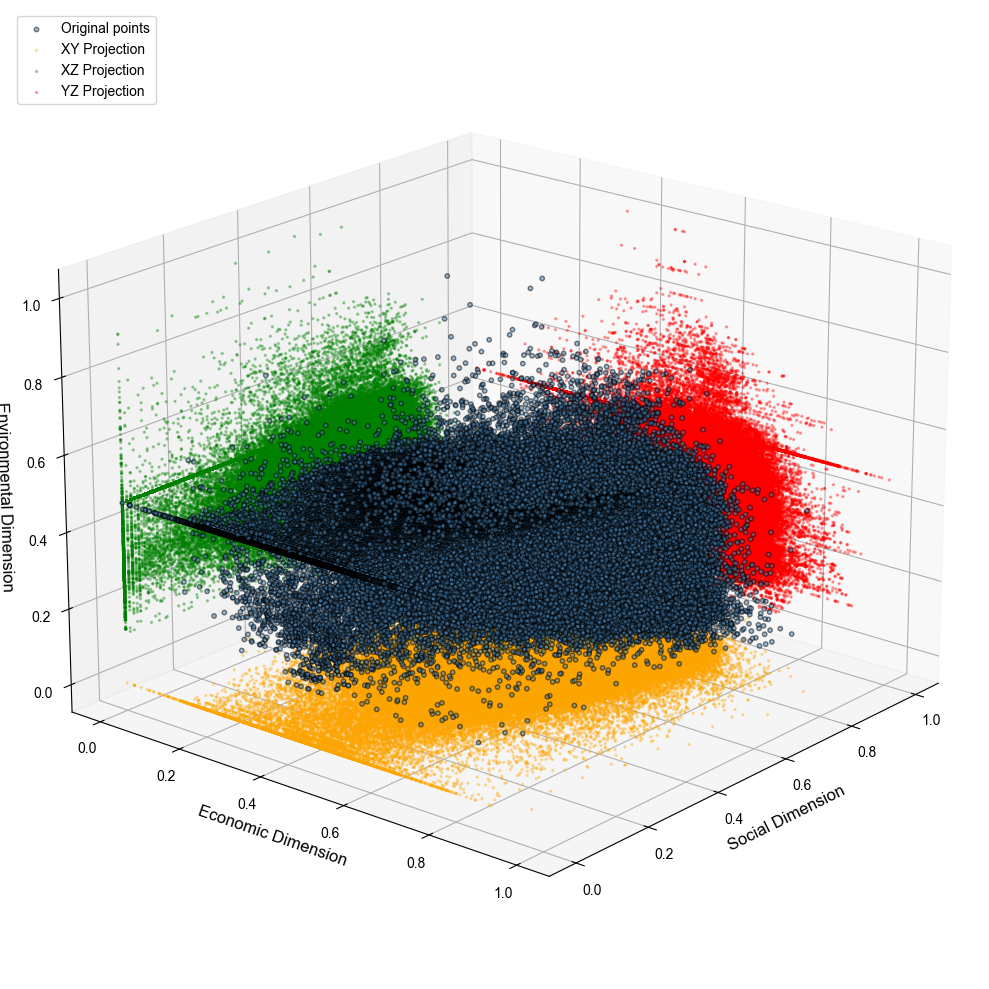

In [23]:
# Create 3D figure
fig_3d = plt.figure(figsize=(10, 10))
ax = fig_3d.add_subplot(111, projection='3d')

# Input data vectors
x = df_scaled['log_VIT202311'].values        # Social dimension (Vitality Index)
y = df_scaled['log_NTL2023_focal'].values    # Economic dimension (Nighttime Light)
z = df_scaled['UHIDAY2020_07_inv'].values    # Environmental dimension (Inverted UHI)

# Main 3D scatter plot
ax.scatter(x, y, z, c='steelblue', alpha=0.5, s=10, edgecolors='black', label='Original points')

# Compute min and max values for projection planes
x_min, y_min, z_min = np.min(x), np.min(y), np.min(z)
x_max, y_max, z_max = np.max(x), np.max(y), np.max(z)

# XY-plane projection (Z fixed)
ax.scatter(x, y, np.full_like(x, z_min), c='orange', alpha=0.3, s=2, label='XY Projection')

# XZ-plane projection (Y fixed)
ax.scatter(x, np.full_like(y, y_min), z, c='green', alpha=0.3, s=2, label='XZ Projection')

# YZ-plane projection (X fixed)
ax.scatter(np.full_like(x, x_max), y, z, c='red', alpha=0.3, s=2, label='YZ Projection')

ax.set_xlabel('Social Dimension', fontsize=12)
ax.set_ylabel('Economic Dimension', fontsize=12)
ax.set_zlabel('Environmental Dimension', fontsize=12)
ax.invert_xaxis()
ax.view_init(elev=20, azim=40)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

## 2.2 Clustering and Pareto filtering

Clustering serves multiple purposes in the construction and evaluation of the Pareto frontier. By aggregating blocks with similar performance profiles, clustering reduces local noise and minor fluctuations, allowing the analysis to focus on robust and structurally meaningful Pareto optimal patterns rather than isolated outliers. This aggregation also facilitates improved surface fitting, as estimating the frontier from a smaller and cleaner set of representative points enhances both the stability and interpretability of the resulting approximation. Once the Pareto front is defined using cluster centers, it provides a scalable evaluation framework in which the performance of the full dataset can be efficiently assessed by computing distances from each block to the frontier.

### 2.2.1 K value selection

The dataset was reduced via k-means clustering (K = 5,000), generating cluster centers that closely approximate the empirical distribution while suppressing noise and outliers. We tested a range of clustering granularities (K = 100, 300, 500, 1,000, 1,500, 2,000, 3,000 and 5,000). The final choice of K was guided by sensitivity analysis of downstream model performance, with K = 5,000 yielding the highest predictive accuracy in the subsequent XGBoost model. 

In [14]:
# X_std = df_scaled[targets_processed].values

# from sklearn.cluster import KMeans
# import pandas as pd
# from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
# k_list = [500, 1000, 1500, 2000, 3000, 5000]  # Modify this list as needed
# pareto_results = {}

# for k in k_list:
#     print(f"\n▶ Running KMeans for k = {k}")
    
#     # Run KMeans clustering
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(X_std)
#     centers_std = kmeans.cluster_centers_
#     centers_original = scaler.inverse_transform(centers_std)

#     # Perform Pareto filtering
#     F_inv = -1 * centers_original  # Convert to minimization problem
#     nds = NonDominatedSorting()
#     pareto_idx = nds.do(F_inv, only_non_dominated_front=True)
#     pareto_centers = centers_original[pareto_idx]

#     # Build output DataFrame
#     df = pd.DataFrame(pareto_centers, columns=targets_processed)
#     df['Global_ID'] = [f"cluster_{i}" for i in pareto_idx]
#     df = df[['Global_ID'] + targets_processed]

#     # Store the result
#     pareto_results[f"k{k}"] = df
#     print(f"Selected {len(df)} Pareto-optimal cluster centers for k = {k}")

In [15]:
# df_pareto_centers_k1000 = pareto_results['k1000']
# df_pareto_centers_k1000.describe()

In [16]:
# import os

# # Ensure the output folder exists
# os.makedirs("output", exist_ok=True)

# # Loop through results and save each DataFrame to CSV
# for k in [500, 1000, 1500, 2000, 3000, 5000]:
# # for k in [1000]:
#     df = pareto_results[f'k{k}']
#     output_path = f"../output/pareto_centers_k{k}.csv"
#     df.to_csv(output_path, index=False)
#     print(f"Saved: {output_path}")

## 2.3 PPF construction and efficiency calculation

In [24]:
df_pareto_centers = pd.read_csv(r"../data/pareto_centers_k5000.csv")
print(df_pareto_centers.shape)
df_pareto_centers.head(5)

(49, 4)


Global_ID  log_NTL2023_focal  log_VIT202311  UHIDAY2020_07_inv
0  cluster_231               0.56           0.35               0.90
1  cluster_422               0.80           0.62               0.57
2  cluster_508               0.68           0.79               0.51
3  cluster_758               0.50           0.58               0.98
4  cluster_795               0.70           0.83               0.47

In [25]:
surface_data = df_pareto_centers
sample_data = grid500

# Define variables for the original column names to be used
x_col = 'log_NTL2023_focal'
y_col = 'log_VIT202311'
z_col = 'UHIDAY2020_07_inv'
XY = df_pareto_centers[['log_VIT202311', 'log_NTL2023_focal']].values
z = df_pareto_centers['UHIDAY2020_07_inv'].values

# Extract the 3D points that define the surface
surface_points = surface_data[[x_col, y_col, z_col]].values

# Surface interpolation using RBF
print("Fitting RBFInterpolator model...")
smoothing_factor = 0.05
rbf_model = RBFInterpolator(XY, z, kernel='thin_plate_spline', smoothing=smoothing_factor)  # or {'linear', 'cubic', 'quintic'}

# To calculate the distance, create a dense cloud of points on the RBF surface.
print("Creating a dense point cloud of the fitted surface...")
grid_density = 300 # Higher density means more accurate distances but more computation
x_dense = np.linspace(surface_points[:, 0].min(), surface_points[:, 0].max(), grid_density)
y_dense = np.linspace(surface_points[:, 1].min(), surface_points[:, 1].max(), grid_density)
Xg, Yg = np.meshgrid(x_dense, y_dense)
XY_grid = np.vstack([Xg.ravel(), Yg.ravel()]).T

# Predict the Z values for the dense grid to form the surface points
Zg = rbf_model(XY_grid)
dense_surface_points = np.hstack([XY_grid, Zg.reshape(-1, 1)])

# Calculate true Euclidean distance to surface using KDTree
# Build the KDTree from the dense surface point cloud
print("Building KDTree for efficient distance calculation...")
surface_tree = KDTree(dense_surface_points)

# Extract the 3D coordinates of the sample points
sample_points_3d = sample_data[[x_col, y_col, z_col]].values

# For each sample point, find the distance to the nearest point on the dense surface
print("Querying KDTree to find shortest distances...")
distances, _ = surface_tree.query(sample_points_3d)

# Add the calculated distances as a new column to the dataframe
sample_data['distance_to_surface'] = distances

# The performance is defined as 1 minus the normalized distance
min_dist = distances.min()
max_dist = distances.max()

# Normalize the distances to be between 0 and 1
epsilon = 1e-9
normalized_distances = (distances - min_dist) / (max_dist - min_dist + epsilon)

# The performance score is 1 minus the normalized distance
performance_score = 1 - normalized_distances

# Add the performance score as a new column
sample_data['performance_score'] = performance_score

Fitting RBFInterpolator model...
Creating a dense point cloud of the fitted surface...
Building KDTree for efficient distance calculation...
Querying KDTree to find shortest distances...


In [19]:
sample_data['performance_score'].describe()

count   194941.00
mean         0.66
std          0.14
min          0.00
25%          0.59
50%          0.68
75%          0.75
max          1.00
Name: performance_score, dtype: float64


Generating visualization...


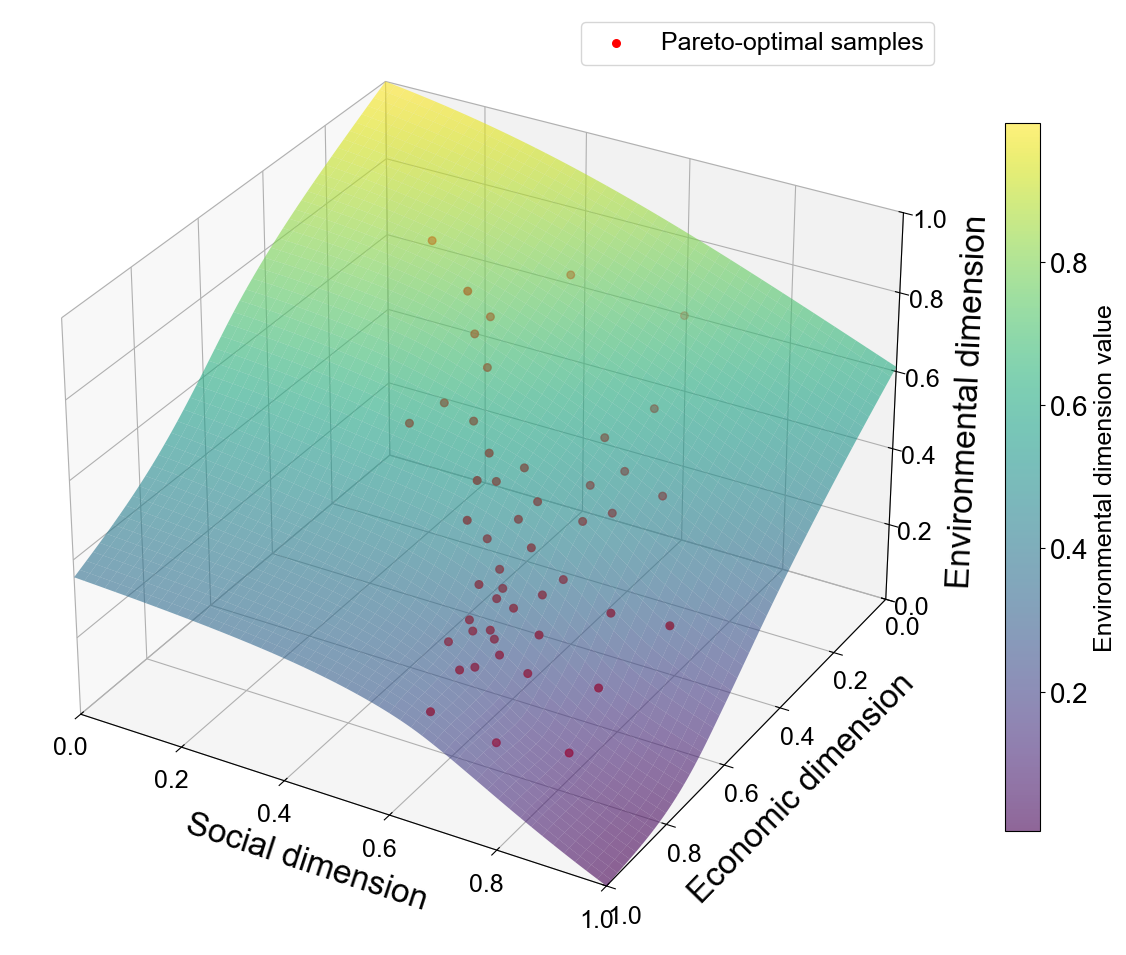

In [26]:
# Visualize surface and Pareto points
print("\nGenerating visualization...")
fig = plt.figure(figsize=(12, 18))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white') 
ax.set_facecolor('white')

def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

Xn = minmax(Xg)
Yn = minmax(Yg)
Zn = minmax(Zg)

surface_n = np.column_stack([
    minmax(surface_points[:, 0]),
    minmax(surface_points[:, 1]),
    minmax(surface_points[:, 2])
])

# X_range_min = np.min(x_dense)
# X_range_max = np.max(x_dense)

# Y_range_min = np.min(y_dense)
# Y_range_max = np.max(y_dense)

# Z_range_min = np.min(Zg)
# Z_range_max = np.max(Zg)

# print(f"X (log_VIT202311): [{X_range_min:.4f}, {X_range_max:.4f}]")
# print(f"Y (log_NTL2023_focal): [{Y_range_min:.4f}, {Y_range_max:.4f}]")
# print(f"Z (UHIDAY2020_07_inv): [{Z_range_min:.4f}, {Z_range_max:.4f}]")

# For visualization, we can use the same meshgrid as for the dense points
surf = ax.plot_surface(
    Xn, Yn, Zn.reshape(Xn.shape),
    cmap='viridis',
    alpha=0.6,
    linewidth=0,
    antialiased=True
)

# Plot the original Pareto points that were used to define the surface.
scatter = ax.scatter(
    surface_points[:, 0],
    surface_points[:, 1],
    surface_points[:, 2],
    c='red',
    s=30,
    depthshade=True,
    label='Pareto-optimal samples'
)

# Set labels and title
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
ax.set_zlim(0, 1)

cbar = fig.colorbar(
    surf,
    ax=ax,
    shrink=0.4,      # controls height
    pad=0.05          # distance from plot
)

# colorbar
cbar.set_label(
    'Environmental dimension value',
    fontsize=18
)
cbar.ax.tick_params(labelsize=20)

ax.legend(
    loc='upper right',
    fontsize=18
)

ax.set_xlabel('Social dimension', fontsize=24, labelpad=12) # \n(log_VIT202311)
ax.set_ylabel('Economic dimension', fontsize=24, labelpad=12) # \n(log_NTL2023_focal)
ax.set_zlabel('Environmental dimension', fontsize=24, labelpad=12) # \n(UHIDAY2020_07_inv)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='z', labelsize=18)

plt.tight_layout()

# Save the figure
# plt.savefig('pareto_surface_visualization_rbf.png')

## 2.4 Performance score analyses

In [27]:
sample_data['performance_score'].describe()

count   194941.00
mean         0.66
std          0.14
min          0.00
25%          0.59
50%          0.68
75%          0.75
max          1.00
Name: performance_score, dtype: float64

### 2.4.1 City-level analyses

In [28]:
# city-level
distribution = sample_data.groupby('City')['performance_score'].agg(
    [('Count', 'count'), 
     ('Mean', 'mean'),     
     ('Median', 'median'), 
     ('Std Dev', 'std'),   
     ('Min', 'min'),       
     ('Max', 'max')]       
).round(2)

distribution
# distribution.to_csv("../output/performance_score_analyses/performance_score_city.csv")

Count  Mean  Median  Std Dev  Min  Max
City                                                
Beijing       14617  0.59    0.61     0.11 0.07 0.90
Changchun      5892  0.63    0.66     0.14 0.07 0.96
Changsha       3324  0.70    0.71     0.11 0.13 1.00
Chengdu        7570  0.72    0.73     0.10 0.20 1.00
Chongqing      6498  0.68    0.69     0.12 0.16 0.98
Dalian         5603  0.60    0.62     0.15 0.07 1.00
Fuzhou         2214  0.66    0.68     0.13 0.16 0.99
Guangzhou      9623  0.69    0.71     0.11 0.19 1.00
Guiyang        2658  0.67    0.68     0.13 0.16 1.00
Haikou         1390  0.71    0.73     0.13 0.23 1.00
Hangzhou       7558  0.67    0.68     0.12 0.15 1.00
Harbin         5327  0.58    0.60     0.15 0.02 0.90
Hefei          3417  0.74    0.76     0.11 0.23 1.00
Hohhot         2227  0.68    0.70     0.12 0.17 0.96
Jinan          6886  0.62    0.64     0.12 0.09 0.98
Kunming        3494  0.69    0.71     0.14 0.15 1.00
Lanzhou        3131  0.67    0.67     0.20 0.04 1.00
Lasa           1025  0.62    0.65     0.17 0.14 0.94
Nanchang       2797  0.70    0.71     0.13 0.19 0.97
Nanjing        7637  0.68    0.70     0.13 0.15 1.00
Nanning        2916  0.74    0.76     0.14 0.22 1.00
Ningbo         4459  0.72    0.74     0.11 0.19 0.99
Qingdao        8063  0.65    0.67     0.13 0.14 0.96
Shanghai      15331  0.67    0.69     0.10 0.12 0.99
Shenyang       6573  0.56    0.59     0.14 0.05 0.96
Shenzhen       6009  0.73    0.76     0.13 0.21 1.00
Shijiazhuang   2941  0.60    0.61     0.11 0.08 0.81
Taiyuan        2992  0.68    0.70     0.14 0.12 0.99
Tianjin       12170  0.60    0.62     0.14 0.00 0.98
Urumqi         5413  0.61    0.62     0.17 0.07 1.00
Wuhan          8537  0.71    0.73     0.13 0.17 1.00
Xiamen         2667  0.75    0.77     0.12 0.27 0.99
Xian           5184  0.75    0.77     0.10 0.27 1.00
Xining         1542  0.62    0.65     0.15 0.15 0.99
Yinchuan       1883  0.66    0.68     0.13 0.15 0.94
Zhengzhou      5373  0.66    0.68     0.12 0.01 0.99

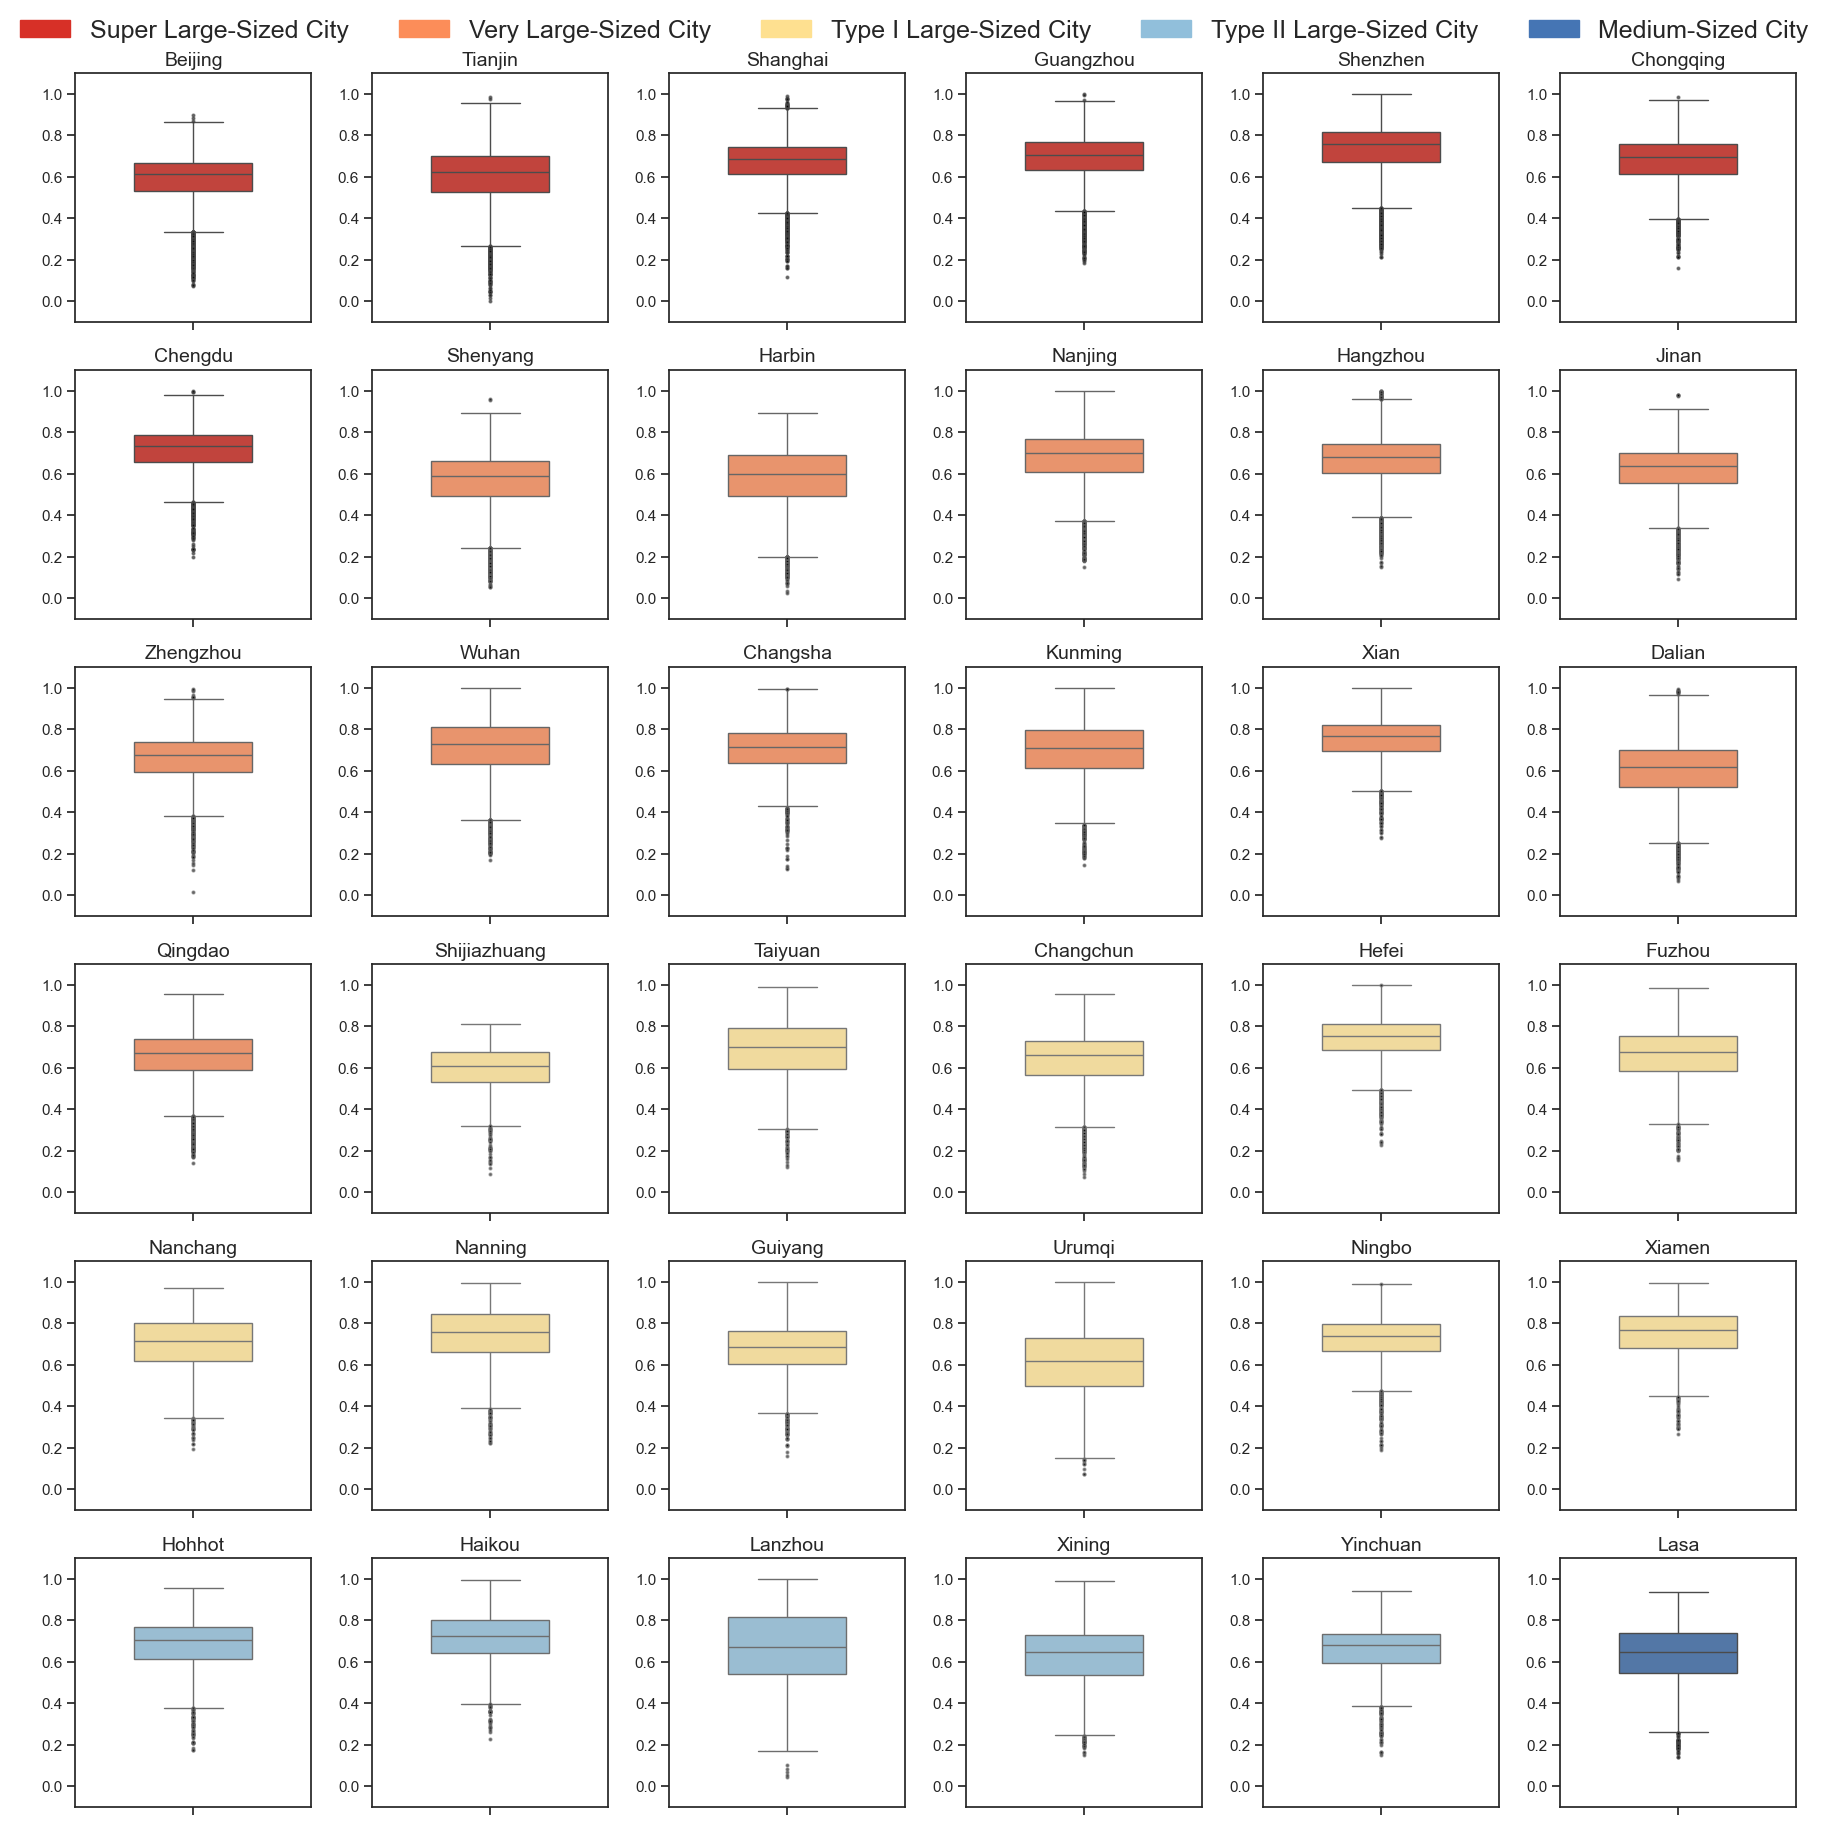

In [36]:
# Define colors for each category
category_colors = {
    'Super Large-Sized City': '#d73027',  # Red
    'Very Large-Sized City': '#fc8d59',   # Orange
    'Type I Large-Sized City': '#fee090', # Yellow/Cream
    'Type II Large-Sized City': '#91bfdb',# Light Blue
    'Medium-Sized City': '#4575b4'        # Dark Blue
}

# Invert existing dictionary for easier lookup (City -> Category)
city_categories = {
    'Super Large-Sized City': ['Beijing', 'Tianjin', 'Shanghai', 'Guangzhou', 'Shenzhen', 'Chongqing', 'Chengdu'],
    'Very Large-Sized City': ['Shenyang', 'Harbin', 'Nanjing', 'Hangzhou', 'Jinan', 'Zhengzhou', 'Wuhan', 'Changsha', 'Kunming', 'Xian', 'Dalian', 'Qingdao'],
    'Type I Large-Sized City': ['Shijiazhuang', 'Taiyuan', 'Changchun', 'Hefei', 'Fuzhou', 'Nanchang', 'Nanning', 'Guiyang', 'Urumqi', 'Ningbo', 'Xiamen'],
    'Type II Large-Sized City': ['Hohhot', 'Haikou', 'Lanzhou', 'Xining', 'Yinchuan'],
    'Medium-Sized City': ['Lasa']
}

city_to_category = {}
for category, city_list in city_categories.items():
    for city in city_list:
        city_to_category[city] = category

# Setup plotting
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
axes = axes.flatten()

flier_style = dict(
    marker='o',
    markerfacecolor='black',
    markersize=2,
    linestyle='None',
    alpha=0.6
)

for i, city in enumerate(city_to_category):
    ax = axes[i]
    
    # Determine the color based on the city's category
    # Default to grey if city is missing from the dict
    cat = city_to_category.get(city, "Unknown")
    box_color = category_colors.get(cat, "lightgrey")
    
    sns.boxplot(
        data=sample_data[sample_data['City'] == city],
        y="performance_score",
        ax=ax,
        color=box_color,
        showfliers=True,
        flierprops=flier_style,
        width=0.5
    )
    
    ax.set_title(city, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(-0.1, 1.1)

# Clean up empty subplots
for j in range(len(city_to_category), 36):
    fig.delaxes(axes[j])

# Create handle objects for the legend
legend_patches = [
    mpatches.Patch(color=color, label=label) 
    for label, color in category_colors.items()
]

# Place legend at the top of the figure
fig.legend(
    handles=legend_patches, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.02), # Push slightly above the plot
    ncol=5,
    fontsize=18,
    frameon=False
)

plt.tight_layout()
plt.show()

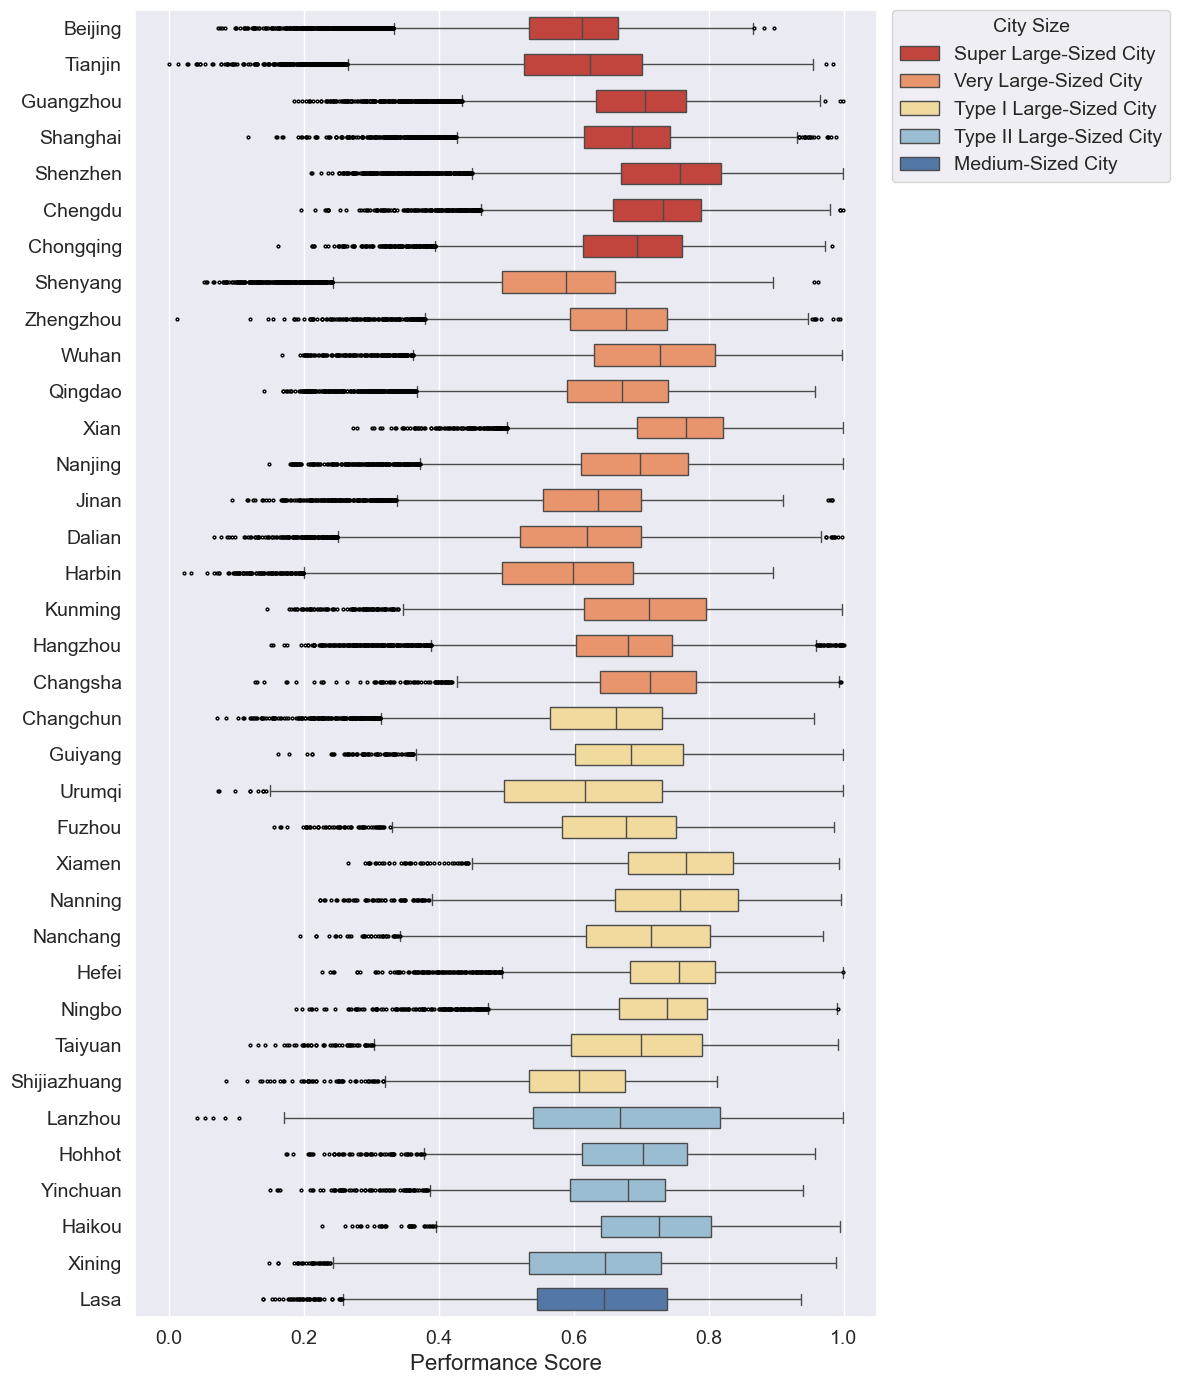

In [37]:
# 1. Prepare Data
# Invert dictionary to map City -> Category
city_to_category = {}
for category, city_list in city_categories.items():
    for city in city_list:
        city_to_category[city] = category

# Apply this mapping to create a new column
sample_data['City_Category'] = sample_data['City'].map(city_to_category)

# Create a custom sort order based on your category keys
category_order = list(city_categories.keys())
sample_data['City_Category'] = pd.Categorical(
    sample_data['City_Category'], 
    categories=category_order, 
    ordered=True
)
sample_data = sample_data.sort_values('City_Category')

# 2. Setup Plotting
sns.set_theme(style="darkgrid") 
fig, ax = plt.subplots(figsize=(12, 14))

# Define colors
category_colors = {
    'Super Large-Sized City': '#d73027',
    'Very Large-Sized City': '#fc8d59',
    'Type I Large-Sized City': '#fee090',
    'Type II Large-Sized City': '#91bfdb',
    'Medium-Sized City': '#4575b4'
}

# Define fliers
flier_style = dict(
    marker='o',
    # markerfacecolor='black',
    markeredgecolor='black',
    markersize=2,
    linestyle='None',
    alpha=1
)

# 3. Create the Horizontal Boxplot
sns.boxplot(
    data=sample_data,
    x="performance_score",  # Numeric variable on X
    y="City",               # Categorical variable on Y
    hue="City_Category",    # Color based on category
    palette=category_colors,
    dodge=False,            # Important: prevents boxes from shrinking
    width=0.6,              # Adjusts thickness of the bars
    ax=ax,
    flierprops=flier_style
)

# 4. Formatting
# ax.set_title("Performance Score by City", fontsize=16, fontweight='bold')
ax.set_xlabel("Performance Score", fontsize=16)
ax.set_ylabel("")

ax.legend(
    title='City Size', 
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0,
    fontsize=14,
    title_fontsize=14
)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
# plt.savefig("../output/performance_score_analyses/city_level_boxplot.png", dpi=600)
plt.show()

### 2.4.2 City-size-category analyses

In [38]:
# Define the logical order for the y-axis
custom_order = [
    'Super Large-Sized City', 
    'Very Large-Sized City', 
    'Type I Large-Sized City', 
    'Type II Large-Sized City', 
    'Medium-Sized City'
]

In [39]:
sample_data.head()

Global_ID     City  NTL2023  NTL2023_focal  VIT202311  \
0               0  Beijing     6.18           7.03    1649.86   
161301     161301  Tianjin    31.25          43.48     250.86   
161302     161302  Tianjin    40.39          47.46     785.43   
161303     161303  Tianjin    44.26          48.26    2173.43   
161304     161304  Tianjin    47.75          48.00    1591.00   

        UHIDAY2020_07_inv  buildingCount  totalHeight  avgHeight  maxHeight  \
0                    0.47             31        93.00       3.00       3.00   
161301               0.21             17       346.50      20.38      27.00   
161302               0.19             63      1245.00      19.76      27.50   
161303               0.19             75      1690.50      22.54      27.00   
161304               0.19             71      1637.00      23.06      82.00   

        minHeight  heightRange  heightIndex  heightDensity  heightOtherness  \
0            3.00         0.00         0.03           0.00             0.00   
161301      12.00        15.00         0.08           0.00             0.19   
161302      12.00        15.50         0.02           0.00             0.22   
161303      12.00        15.00         0.02           0.01             0.23   
161304      12.00        70.00         0.05           0.01             0.51   

        cornerCountTotal  basePerimeterTotal  basePerimeterAvg  \
0                    180             6500.98            209.71   
161301               127             2355.24            138.54   
161302               380             5602.16             88.92   
161303               519             8142.02            108.56   
161304               426             5206.74             73.33   

        basePerimeterMax  basePerimeterMin  shapeComplexity  compactness  \
0                 831.63             32.55             5.07         0.56   
161301            359.20             10.63             5.32         0.51   
161302            345.65             12.25             4.82         0.59   
161303            264.47             13.34             4.82         0.57   
161304            215.72              1.10             4.73         0.60   

        footprintAreaTotal  totalArea  areaVariance  avgBuildingArea  \
0                 88704.58   88704.58   50961857.70          2861.44   
161301            22421.34  157711.27  280869832.40          9277.13   
161302            26560.06  187715.04   14881184.26          2979.60   
161303            44480.80  342918.28   17132172.22          4572.24   
161304            22830.16  197508.34   23652455.38          2781.81   

        parcelArea  largestPatchIndex  shape3DIndex  SVF  evennessIndex  FAR  \
0        132998.25               0.47          0.01 0.80         234.60 0.35   
161301   242999.92               0.63          0.01 0.92         402.22 0.63   
161302   225369.63               0.43          0.01 0.89         182.25 0.75   
161303   250000.00               1.00          0.00 0.80         213.64 1.37   
161304   242359.06               0.90          0.87 0.82         244.14 0.79   

        coverageRatio  FVC  permeableRatio  poiDensity  poiDiversity  \
0                0.35 0.84            0.89        4.00          0.00   
161301           0.09 0.65            0.78       88.00          1.49   
161302           0.11 0.59            0.76       16.00          1.39   
161303           0.18 0.61            0.77        4.00          0.00   
161304           0.09 0.60            0.69      316.00          1.70   

        streetRatio  roadDensity  intersectionDensity  cornerCountAvg  \
0              0.20            5                    1            5.81   
161301         0.83            1                    0            7.47   
161302         0.60            7                    4            6.03   
161303         0.57            0                    0            6.92   
161304         0.85            1                    0            6.00   

        buildingProximity  

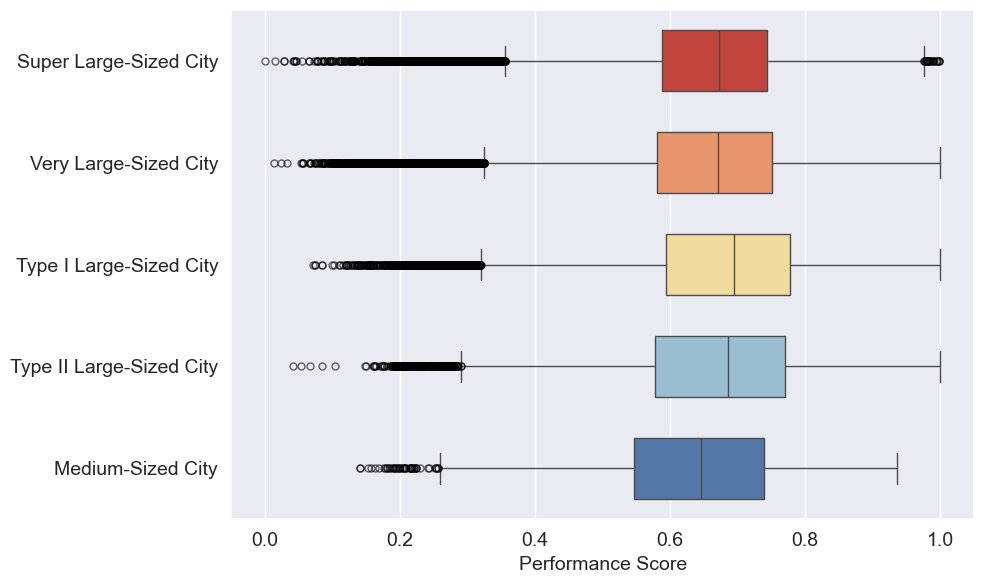

In [40]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 6))

flier_style = dict(
    marker='o',
    # markerfacecolor='black',
    markeredgecolor='black',
    markersize=5,
    linestyle='None',
    alpha=0.6
)

sns.boxplot(
    data=sample_data,
    x="performance_score",
    y="City_Category",
    order=custom_order,
    palette=category_colors,
    width=0.6,
    ax=ax,
    flierprops=flier_style
)

# Formatting
# ax.set_title("Performance Score Distribution by City Size", fontsize=14, fontweight='bold')
ax.set_xlabel("Performance Score", fontsize=14)
ax.set_ylabel("", fontsize=14)

# Adjust tick label size
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Since the Y-labels explain the colors, you don't need a separate legend.
plt.tight_layout()
plt.show()

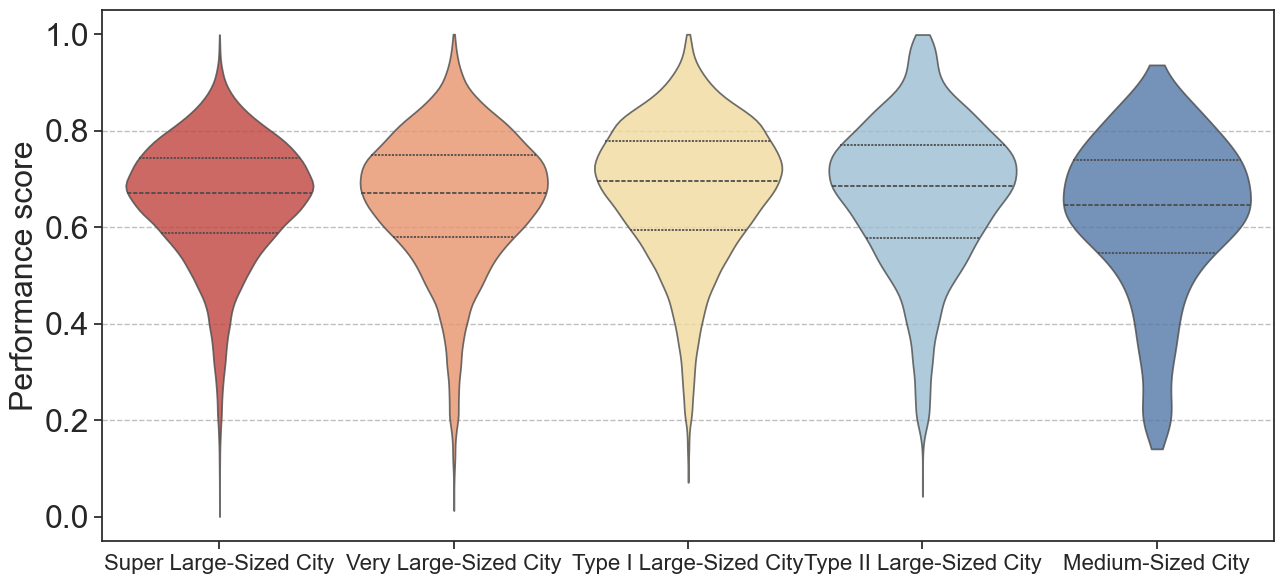

In [43]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.set_theme(style="ticks")

sns.violinplot(
    data=sample_data,
    y="performance_score",
    x="City_Category",
    order=custom_order,
    palette=category_colors,
    inner="quartile", 
    cut=0,
    ax=ax,
    alpha=0.8
)

for y in [0.2, 0.4, 0.6, 0.8]:
    ax.axhline(y=y, color='gray', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

ax.set_ylabel("Performance score", fontsize=23)
ax.set_xlabel("", fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=23)
plt.tight_layout()
# plt.savefig("../output/performance_score_analyses/category_boxplot.png", dpi=600)
plt.show()

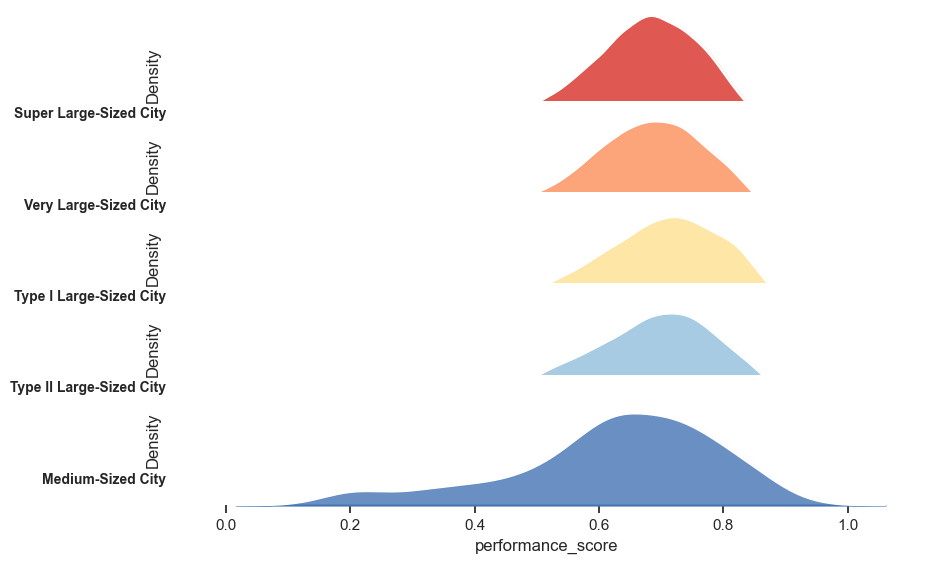

In [42]:
# Create a FacetGrid (one row per category)
g = sns.FacetGrid(
    sample_data, 
    row="City_Category", 
    hue="City_Category", 
    aspect=7, 
    height=1.2, 
    palette=category_colors,
    row_order=custom_order
)

# Draw the densities
g.map(sns.kdeplot, "performance_score", clip_on=False, shade=True, alpha=0.8, lw=1.5)
g.map(sns.kdeplot, "performance_score", clip_on=False, color="w", lw=2) # White outline

# Formatting to make it look like a Ridgeline
g.fig.subplots_adjust(hspace=-0.3) # Overlap the plots
g.set_titles("") # Remove default titles
g.set(yticks=[]) # Remove y-ticks
g.despine(bottom=True, left=True)

# Add labels manually to the left
for ax, label in zip(g.axes.flat, custom_order):
    ax.text(0, 0.2, label, fontweight="bold", fontsize=10, 
            ha="right", va="center", transform=ax.transAxes)

plt.show()

# 3. Model training

In [44]:
grid500.describe()

Global_ID   NTL2023  NTL2023_focal  VIT202311  UHIDAY2020_07_inv  \
count  194941.00 189742.00      194941.00  194941.00          194941.00   
mean    98137.51     28.88          28.65    1414.14               0.37   
std     56862.94     19.36          17.87    1821.23               0.10   
min         0.00      0.00           0.00       0.00               0.00   
25%     49033.00     15.06          15.64     206.86               0.30   
50%     97800.00     25.85          26.01     731.14               0.38   
75%    147135.00     38.67          38.17    2003.43               0.47   
max    196769.00    465.96         348.37   68494.71               1.00   

       buildingCount  totalHeight  avgHeight  maxHeight  minHeight  \
count      194941.00    194941.00  194941.00  194941.00  194941.00   
mean           46.70       893.91      16.53      30.42       9.58   
std            50.96      1035.48       8.72      24.26       4.91   
min             0.00         0.00       0.00       0.00       0.00   
25%            12.00       144.00      12.00      12.00       6.00   
50%            35.00       559.00      16.67      27.00      12.00   
75%            65.00      1315.00      21.99      40.00      12.00   
max          1189.00     22354.50     130.50     535.00     112.00   

       heightRange  heightIndex  heightDensity  heightOtherness  \
count    194941.00    194941.00      194941.00        194941.00   
mean         20.83         0.10           0.00             0.30   
std          23.99         0.17           0.00             0.28   
min           0.00         0.00           0.00             0.00   
25%           0.00         0.02           0.00             0.00   
50%          15.00         0.04           0.00             0.28   
75%          28.00         0.09           0.01             0.43   
max         532.00         1.00           0.09             2.87   

       cornerCountTotal  basePerimeterTotal  basePerimeterAvg  \
count         194941.00           194941.00         194941.00   
mean             315.42             4959.32            112.06   
std              352.35             4245.40             60.43   
min                0.00                0.00              0.00   
25%               72.00             1417.38             83.02   
50%              222.00             4200.02            110.75   
75%              445.00             7512.92            137.30   
max             8619.00            50912.47           1689.25   

       basePerimeterMax  basePerimeterMin  shapeComplexity  compactness  \
count         194941.00         194941.00        194941.00    194941.00   
mean             347.82             22.65             4.55         0.54   
std              230.34             35.73             1.40         0.17   
min                0.00              0.00             0.00         0.00   
25%              202.45              4.35             4.57         0.53   
50%              319.04             14.07             4.82         0.57   
75%              461.66             28.38             5.08         0.62   
max             5146.21           1689.25            39.49         0.99   

       footprintAreaTotal  totalArea    areaVariance  avgBuildingArea  \
count           194941.00  194941.00       194941.00        194941.00   
mean             33192.68  216494.27    191423545.70          5437.01   
std              27474.13  210010.02   2300870309.71          7776.02   
min                  0.00       0.00            0.00             0.00   
25%               8888.17   37241.51      3519241.57          1875.57   
50%              29057.71  157756.72     20726892.83          4027.77   
75%              51784.69  347326.83     74777609.98          6726.97   
max             226640.62 3672930.95 662000000000.00        664544.83   

       parcelArea  largestPatchIndex  shape3DIndex       SVF  evennessIndex  \
count   194941.00          194941.00     194941.00 194941.00      194941.00   
mean    180006.93 

In [ ]:
# grid500.to_csv(r"../output/grid500_performance_score.csv")

In [45]:
grid500 = pd.read_csv(r"../data/grid500_performance_score.csv", index_col=0)

In [ ]:
# gdb_path = r"D:\008RA\gis_process\CN_City36\CN_City36_t1.gdb"
# layer_name = "全国网格"

# gdf = gpd.read_file(gdb_path, layer=layer_name)

# gdf_joined = gdf.merge(grid500, on="Global_ID", how="left")

# output_gdb = r"D:\008RA\gis_process\CN_City36\CN_City36_t2.gdb"
# output_layer = "全国网格_绩效t7"

# pyogrio.write_dataframe(
#     gdf_joined,
#     output_gdb,
#     layer=output_layer,
#     driver="OpenFileGDB"
# )

In [ ]:
# Set global random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Ensure output directories exist
os.makedirs("../model/models", exist_ok=True)
os.makedirs("../model/param_logs", exist_ok=True)

In [ ]:
# # ========================= XGBoost Training Loop =========================
# targets = ['performance_score']

# for target in targets:
#     print(f"\n===== Training model for target: {target} =====")

#     # Filter rows with non-missing values for target and features
#     df_target = grid500.copy()
    
#     # Split features and target
#     X = df_target[features]
#     y = df_target[target]

#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=SEED
#     )

#     print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

#     # Define base XGBoost model
#     xgb_model = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         device='cuda',
#         random_state=SEED,
#         n_jobs=-1
#     )

#     # Randomized hyperparameter search
#     param_dist = {
#         'n_estimators': [500, 1000], 
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [5, 7, 9],
#         'subsample': [0.7, 0.8, 0.9],
#         'colsample_bytree': [0.7, 0.8, 0.9],
#         'min_child_weight': [10, 30, 50],
#         'reg_alpha': [0.1, 1, 10],
#         'reg_lambda': [1, 5, 10],
#     }
    
#     random_search = RandomizedSearchCV(
#         estimator=xgb_model,
#         param_distributions=param_dist,
#         n_iter=200,
#         cv=5,
#         scoring='neg_mean_squared_error',
#         verbose=1,
#         random_state=SEED
#     )

#     # Fit model
#     random_search.fit(X_train, y_train)

#     # Retrieve best estimator
#     best_model = random_search.best_estimator_

#     # Save trained model
#     model_path = f"../output/models2/{target}_xgb_model.pkl"
#     joblib.dump(best_model, model_path)
#     print(f"✔ Saved best model to: {model_path}")

#     # Save best hyperparameters
#     best_params = random_search.best_params_
#     param_path = f"../output/param_logs2/{target}_best_params.json"
#     with open(param_path, 'w') as f:
#         json.dump(best_params, f, indent=4)
#     print(f"✔ Saved best parameters to: {param_path}")

#     # Evaluate model performance
#     y_pred_train = best_model.predict(X_train)
#     y_pred_test = best_model.predict(X_test)

#     train_rmse = root_mean_squared_error(y_train, y_pred_train)
#     test_rmse = root_mean_squared_error(y_test, y_pred_test)
#     test_r2 = r2_score(y_test, y_pred_test)

#     print(f"Train RMSE: {train_rmse:.4f}")
#     print(f"Test  RMSE: {test_rmse:.4f}")
#     print(f"Test   R² : {test_r2:.4f}")

# print("\n✅ All models trained successfully.")

# 4. Model interpretation

## 4.1 Model evaluation metrics

In [49]:
model_dir = "../model/models"
models = {}

# Loop through each target, load the model and store in dict
targets = ['performance_score']
for target in targets:
    model_path = os.path.join(model_dir, f"{target}_xgb_model.pkl")
    if os.path.exists(model_path):
        models[target] = joblib.load(model_path)
        print(f"✔ Loaded model for {target}")
    else:
        print(f"⚠ Model file not found: {model_path}")

✔ Loaded model for performance_score


In [54]:
# Model re-evaluate
# Set random seed to match training split
SEED = 42

# Store evaluation metrics for each model
evaluation_results = {}

for target in targets:
    print(target)
    print(f"\n📊 Evaluating model: {target}")
    
    model = models[target]
    print(model.get_params())
    
    # Extract features and target from full dataset
    X = grid500[features].copy()
    y = grid500[target].copy()

    # Use the same split strategy as training
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED
    )

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Compute metrics
    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store results
    evaluation_results[target] = {
        "Train_RMSE": train_rmse,
        "Test_RMSE": test_rmse,
        "Test_R2": test_r2
    }

# Convert to DataFrame
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.reset_index(inplace=True)
df_eval.rename(columns={'index': 'Target'}, inplace=True)
df_eval = df_eval.round(8)

# Save to CSV
# save_path = "../output/model_evaluation_summary.csv"
# df_eval.to_csv(save_path, index=False)
pd.options.display.float_format = "{:.4f}".format
df_eval

performance_score

📊 Evaluating model: performance_score
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': 50, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 500, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 1, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


Target  Train_RMSE  Test_RMSE  Test_R2
0  performance_score      0.0765     0.0918   0.5582

## 4.2 Feature importance

### 4.2.1 Sklearn

In [55]:
# based on XGBoost
# Ensure the output folder exists
os.makedirs("../output/interpret_models", exist_ok=True)

# Dictionary to collect importance data
importance_all = {}

# Loop over targets to compute and store importance
for target in targets:
    model = models[target]
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type='gain')

    # Convert to DataFrame, fill missing features with 0
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=[f'Importance_{target}'])
    importance_df.index.name = 'Feature'
    importance_all[target] = importance_df

# Merge all importance DataFrames on 'Feature'
combined_importance = pd.concat(importance_all.values(), axis=1)
combined_importance.index.name = 'Feature'
combined_importance = combined_importance.fillna(0).reset_index()

# Optional: reorder by average importance across targets
mean_col = combined_importance.iloc[:, 1:].mean(axis=1)
combined_importance.insert(1, 'MeanImportance', mean_col)
combined_importance.sort_values(by='MeanImportance', ascending=False, inplace=True)

# Save to CSV
# combined_csv_path = "../output/interpret_models/feature_importance.csv"
# combined_importance.to_csv(combined_csv_path, index=False)
# print(f"✅ Combined feature importance saved to: {combined_csv_path}")
combined_importance

Feature  MeanImportance  Importance_performance_score
3    basePerimeterTotal          3.1187                        3.1187
9                   FAR          1.5995                        1.5995
7             totalArea          0.8409                        0.8409
12  intersectionDensity          0.7803                        0.7803
13           poiDensity          0.3735                        0.3735
11          roadDensity          0.3352                        0.3352
17            maxHeight          0.2555                        0.2555
19          heightRange          0.2432                        0.2432
28           parcelArea          0.1799                        0.1799
18            minHeight          0.1730                        0.1730
15                  FVC          0.1554                        0.1554
6    footprintAreaTotal          0.1374                        0.1374
14         poiDiversity          0.1192                        0.1192
10        coverageRatio          0.1128                        0.1128
23     cornerCountTotal          0.1073                        0.1073
38                  SVF          0.1031                        0.1031
16       permeableRatio          0.0815                        0.0815
21        heightDensity          0.0639                        0.0639
29    largestPatchIndex          0.0638                        0.0638
32       cornerCountAvg          0.0591                        0.0591
2             avgHeight          0.0591                        0.0591
0         buildingCount          0.0577                        0.0577
22      heightOtherness          0.0545                        0.0545
39          streetRatio          0.0524                        0.0524
1           totalHeight          0.0523                        0.0523
33    buildingProximity          0.0478                        0.0478
4      basePerimeterAvg          0.0465                        0.0465
31        evennessIndex          0.0426                        0.0426
8       avgBuildingArea          0.0407                        0.0407
27         areaVariance          0.0401                        0.0401
5           compactness          0.0396                        0.0396
24     basePerimeterMax          0.0374                        0.0374
26      shapeComplexity          0.0367                        0.0367
20          heightIndex          0.0354                        0.0354
25     basePerimeterMin          0.0337                        0.0337
30         shape3DIndex          0.0323                        0.0323
36      buildingDistAvg          0.0309                        0.0309
35      buildingMaxDist          0.0305                        0.0305
37      buildingDistVar          0.0290                        0.0290
34      buildingMinDist          0.0275                        0.0275

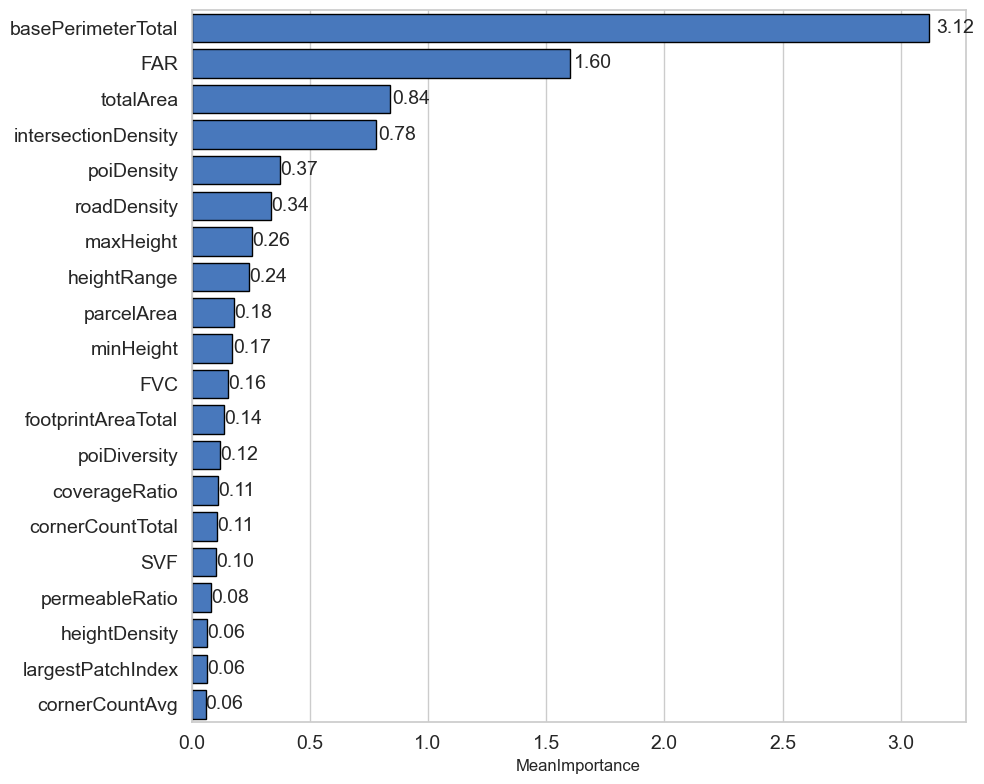

In [56]:
# 1. Select the Top N features to avoid overcrowding
top_n = 20  # Adjust this number based on your needs
plot_data = combined_importance.head(top_n)

# 2. Setup Plot
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid") # Clean background

# 3. Draw the Bar Chart
ax = sns.barplot(
    data=plot_data,
    x="MeanImportance",
    y="Feature",
    color="#3475d0", # Professional blue (or use palette='viridis')
    edgecolor="black" # Adds definition to bars
)

# 4. Formatting
# plt.title(f"Top {top_n} Feature Importance (XGBoost - Gain)", fontsize=16, fontweight='bold')
# plt.xlabel("Average Gain Importance", fontsize=14)
plt.ylabel("") # Remove 'Feature' label as it's obvious

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Add values to the end of the bars (optional but helpful)
for i, v in enumerate(plot_data['MeanImportance']):
    ax.text(v + (v * 0.01), i, f'{v:.2f}', va='center', fontsize=14)

plt.tight_layout()
plt.show()

### 4.2.2 SHAP

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

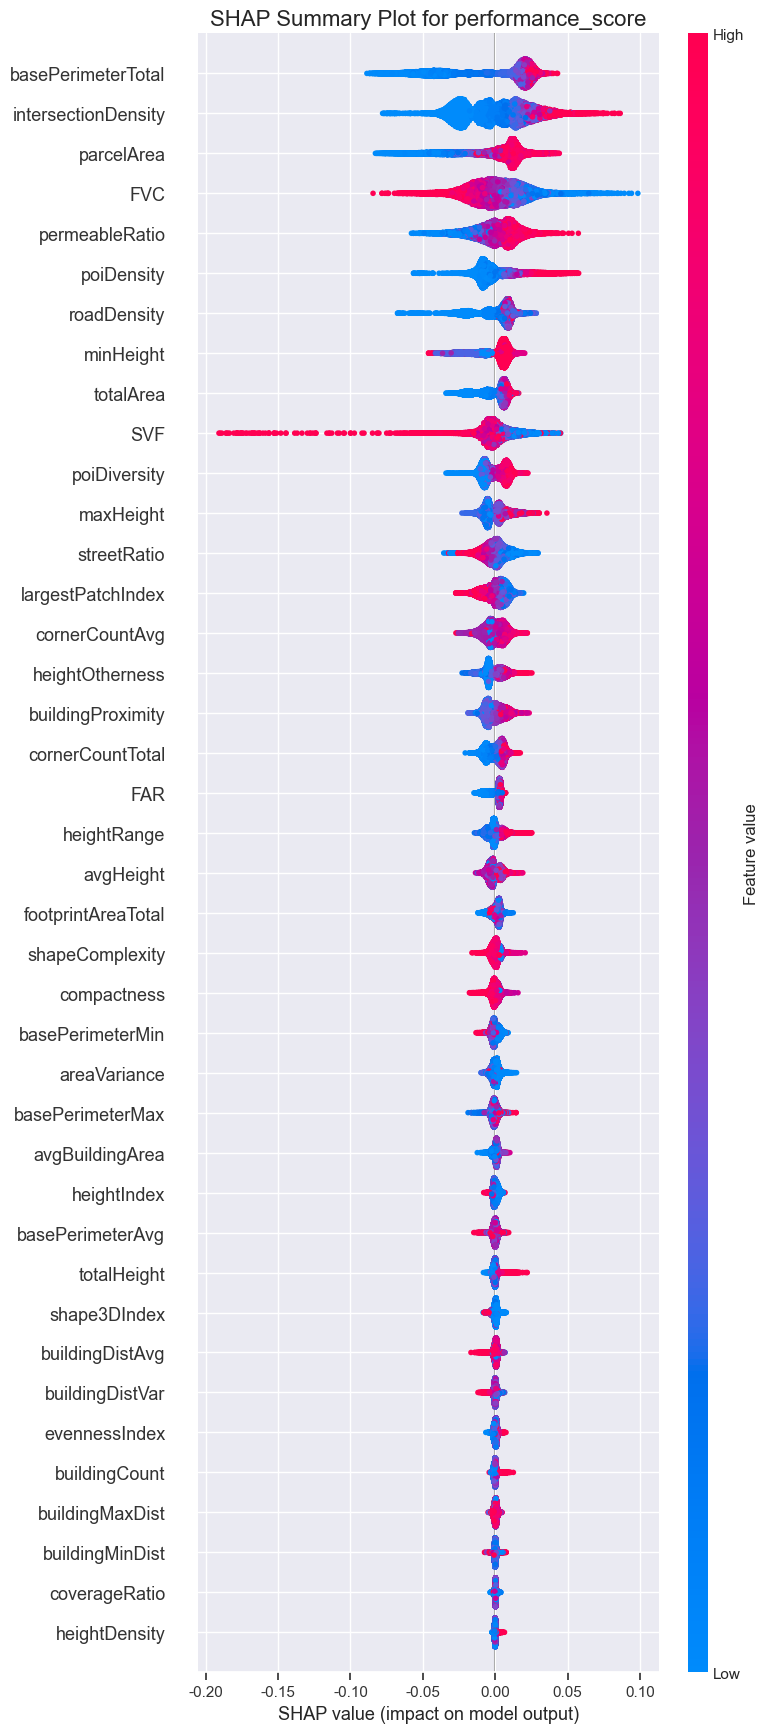

In [ ]:
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1], show=False)
plt.title(f"SHAP Summary Plot for {target}", fontsize=16)
plt.tight_layout()
# Save the figure
# plt.savefig(f"../output/interpret_models/shap_summary_beeswarm_{target}.png", dpi=300)
plt.show()

In [ ]:
# 4. Feature Importance Bar Chart
# This plot simplifies the view by showing the mean absolute SHAP value.
# It only shows "how much" a feature matters, not "how" (positive/negative) it affects the result.
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title(f"Mean Absolute SHAP Values for {target}", fontsize=16)
plt.tight_layout()
# Save the figure
# plt.savefig(f"../output/shap_importance_bar_{target}.png", dpi=300)
plt.show()

In [57]:
X_test.shape

(38989, 40)

In [58]:
X_test.head()

buildingCount  totalHeight  avgHeight  basePerimeterTotal  \
114631             67    1806.5000    26.9627           8993.4092   
152409            110    2137.0000    19.4273          12272.0601   
82786               5     129.0000    25.8000            568.6086   
148798             14     264.0000    18.8571           1850.9385   
129854             86    2222.0000    25.8372           9421.9046   

        basePerimeterAvg  compactness  footprintAreaTotal   totalArea  \
114631          134.2300       0.5308          59724.8095 550052.3471   
152409          111.5642       0.5552          70852.9569 482377.7078   
82786           113.7217       0.4780           3109.0214  25469.4364   
148798          132.2099       0.5670          18810.2534  80978.7195   
129854          109.5570       0.5293          53383.1522 455344.1254   

        avgBuildingArea    FAR  coverageRatio  roadDensity  \
114631        8209.7365 2.2002         0.2389            3   
152409        4385.2519 1.9295         0.2834            4   
82786         5093.8873 0.1019         0.0124            0   
148798        5784.1943 0.3239         0.0752            3   
129854        5294.6991 1.8214         0.2135            5   

        intersectionDensity  poiDensity  poiDiversity    FVC  permeableRatio  \
114631                    4    700.0000        1.7922 0.4347          0.6850   
152409                    5     16.0000        1.0397 0.4474          0.6788   
82786                     0     16.0000        0.0000 0.9887          0.9496   
148798                    0      8.0000        0.0000 0.8292          0.9673   
129854                    3    792.0000        2.2988 0.5502          0.6965   

        maxHeight  minHeight  heightRange  heightIndex  heightDensity  \
114631    63.0000    12.0000      51.0000       0.0349         0.0072   
152409    27.0000     3.0000      24.0000       0.0126         0.0085   
82786     31.0000    12.0000      19.0000       0.2403         0.0005   
148798    24.0000    12.0000      12.0000       0.0909         0.0011   
129854    57.0000    12.0000      45.0000       0.0257         0.0089   

        heightOtherness  cornerCountTotal  basePerimeterMax  basePerimeterMin  \
114631           0.5570               473          515.9588            0.9934   
152409           0.3183               655          246.7964            8.3735   
82786            0.2745                29          151.5042           66.8560   
148798           0.3149                73          438.6431           31.7049   
129854           0.2518               753          279.3041            0.6091   

        shapeComplexity   areaVariance  parcelArea  largestPatchIndex  \
114631           5.1686 173938692.0000 233324.2565             0.6251   
152409           5.0564  18670975.9900 225575.1505             0.6037   
82786            5.9938  21991036.4300  34749.9414             0.1390   
148798           5.0184 122999591.2000  77345.2288             0.3094   
129854           5.2094  24455778.4400 232730.4165             0.3795   

        shape3DIndex  evennessIndex  cornerCountAvg  buildingProximity  \
114631        1.7028       642.8673          7.0597            35.1040   
152409        0.0106       270.6749          5.9545            30.8008   
82786         0.0081        56.2735          5.8000            25.4609   
148798        0.0075       239.9246          5.2143            41.8370   
129854        3.4328       273.5593          8.7558            32.5768   

        buildingMinDist  buildingMaxDist  buildingDistAvg  buildingDistVar  \
114631           9.5081         590.9889         258.7079        2527.6826   
152409           8.2305         662.0632         270.0103        1914.6512   
82786           21.0800         100.9661          47.6119          28.1900   
148798           8.4359         495.6411         163.5438        2559.5819   
129854           6.4572         701.6781         279.8810        2134.6728   

          SVF  street

## 4.3 SHAP-based PDPs

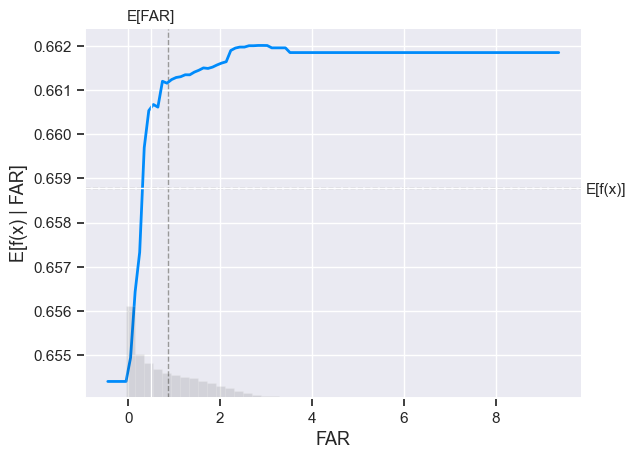

In [270]:
shap.partial_dependence_plot(
    "FAR",
    model.predict,
    X_test,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

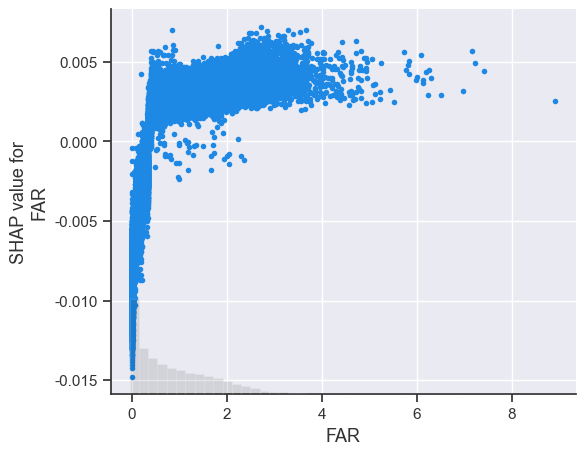

In [271]:
shap.plots.scatter(shap_values[:, "FAR"])

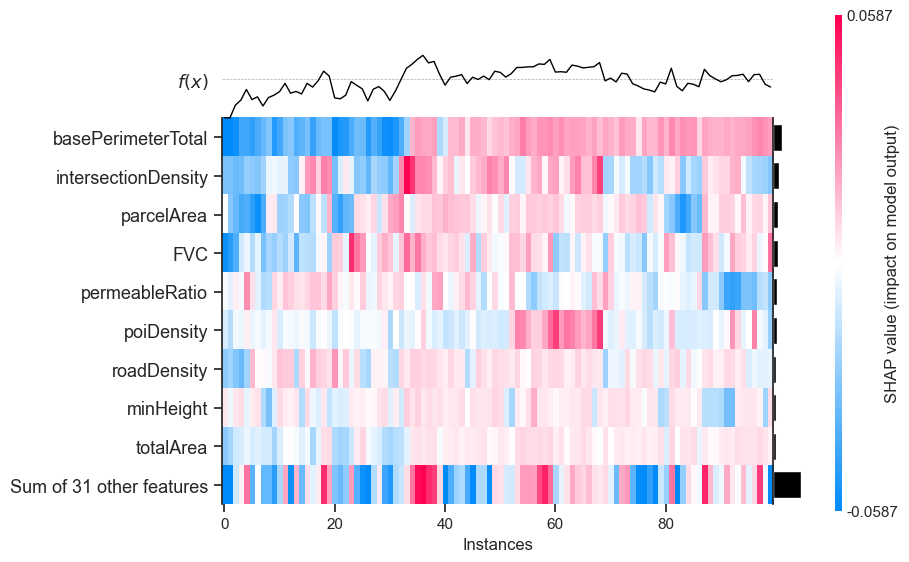

<Axes: xlabel='Instances'>

In [359]:
shap.plots.heatmap(shap_values[:100])

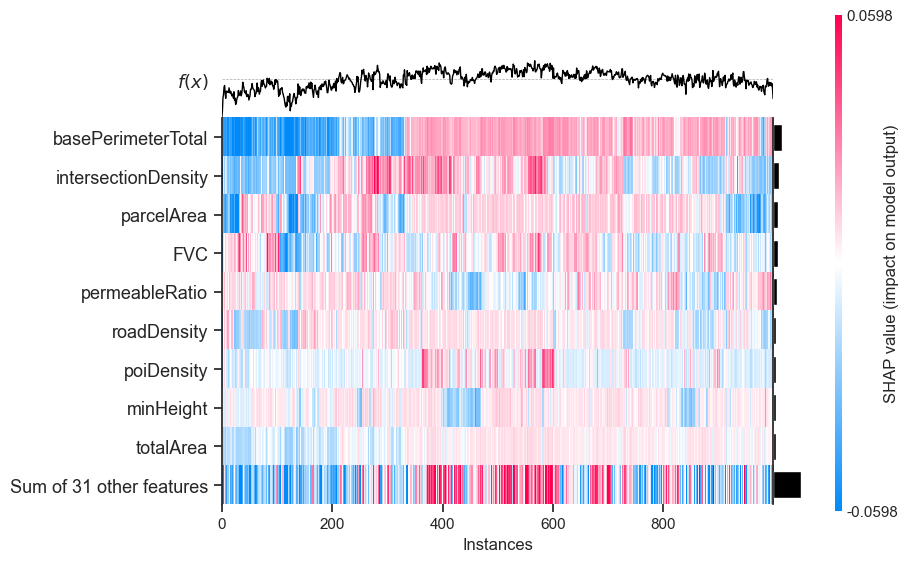

<Axes: xlabel='Instances'>

In [358]:
shap.plots.heatmap(shap_values[:1000])

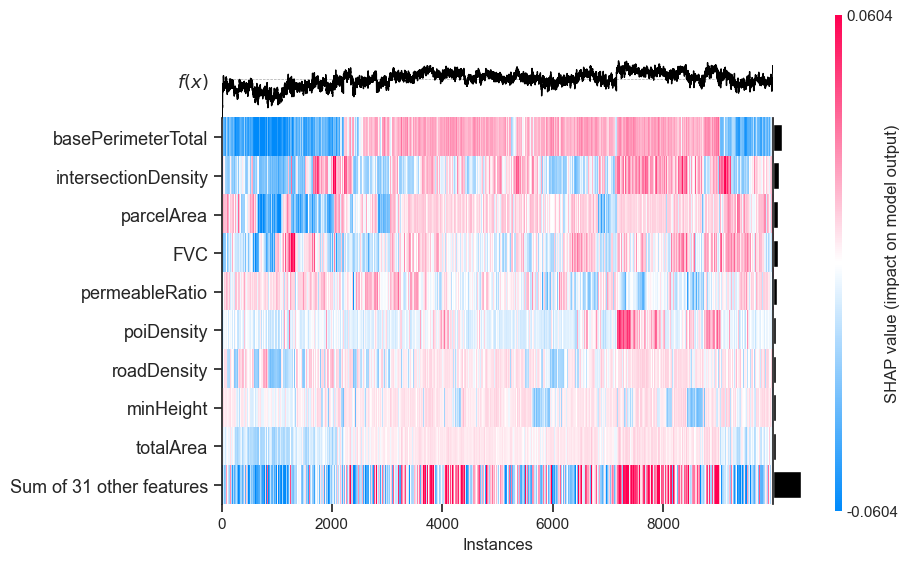

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values[:10000])

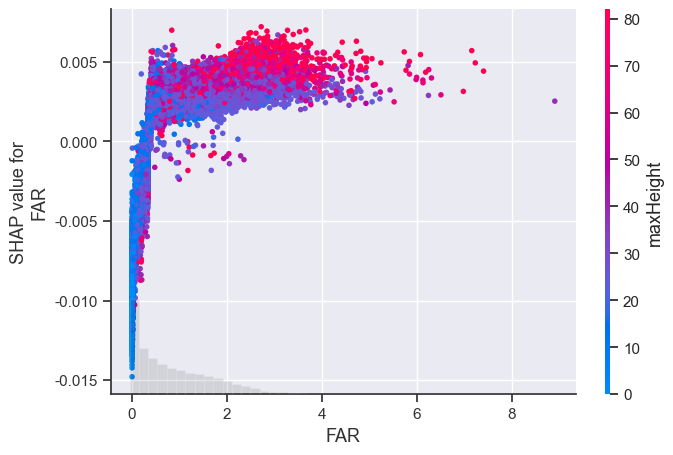

In [278]:
shap.plots.scatter(shap_values[:, "FAR"], color=shap_values)

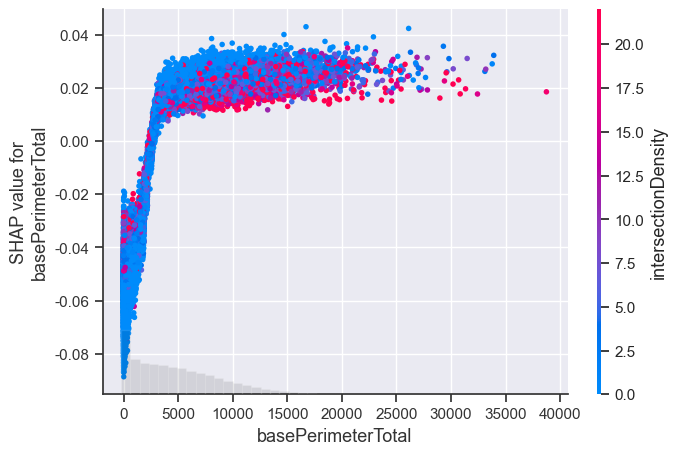

In [280]:
shap.plots.scatter(shap_values[:, "basePerimeterTotal"], color=shap_values)

In [305]:
len(features)

40

In [316]:
save_path = r"../output/interpret_models/SHAP_pdp2" 
os.makedirs(save_path, exist_ok=True)

for feature_name in features:
    print(feature_name)
    
    # 1. Create the figure with the desired size FIRST
    plt.figure(figsize=(10, 10))
    
    # 2. Generate the plot on the active figure (show=False is critical)
    shap.plots.scatter(shap_values[:, feature_name], color=shap_values, show=False)
    
    # 3. Save the figure
    filename = f"scatter_{feature_name}.png"
    full_path = os.path.join(save_path, filename)
    plt.savefig(full_path, bbox_inches='tight', dpi=300)
    
    # 4. Close it to free memory
    plt.close()

print(f"All plots saved to: {save_path}")

buildingCount
totalHeight
avgHeight
basePerimeterTotal
basePerimeterAvg
compactness
footprintAreaTotal
totalArea
avgBuildingArea
FAR
coverageRatio
roadDensity
intersectionDensity
poiDensity
poiDiversity
FVC
permeableRatio
maxHeight
minHeight
heightRange
heightIndex
heightDensity
heightOtherness
cornerCountTotal
basePerimeterMax
basePerimeterMin
shapeComplexity
areaVariance
parcelArea
largestPatchIndex
shape3DIndex
evennessIndex
cornerCountAvg
buildingProximity
buildingMinDist
buildingMaxDist
buildingDistAvg
buildingDistVar
SVF
streetRatio
All plots saved to: ../output/interpret_models/SHAP_pdp2


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

## 4.4 SHAP value clustering

In [154]:
print(type(shap_values))
print(len(shap_values) if isinstance(shap_values, list) else shap_values.shape)

<class 'shap._explanation.Explanation'>
(38989, 40)


In [169]:
X_all = pd.concat([X_train, X_test]).sort_index()
shap_values_all = explainer(X_all)

In [170]:
# converting to DataFrame for easier handling
shap_df = pd.DataFrame(shap_values_all.values, columns=X_all.columns)
shap_df.head()

buildingCount  totalHeight  avgHeight  basePerimeterTotal  \
0           0.00         0.00       0.00                0.02   
1          -0.00        -0.00       0.00                0.02   
2          -0.00        -0.00       0.00                0.02   
3          -0.00        -0.00      -0.00               -0.05   
4          -0.00        -0.00      -0.00               -0.05   

   basePerimeterAvg  compactness  footprintAreaTotal  totalArea  \
0             -0.00         0.00               -0.00       0.00   
1             -0.00        -0.00                0.00      -0.01   
2             -0.00        -0.00                0.00      -0.00   
3              0.00        -0.00                0.00      -0.01   
4              0.00         0.00               -0.00      -0.02   

   avgBuildingArea   FAR  coverageRatio  roadDensity  intersectionDensity  \
0            -0.00  0.00          -0.00         0.01                -0.01   
1            -0.00 -0.00           0.00         0.01                -0.01   
2            -0.00 -0.00           0.00         0.00                -0.03   
3            -0.00 -0.01           0.00         0.01                -0.00   
4            -0.00 -0.01          -0.00         0.00                -0.00   

   poiDensity  poiDiversity   FVC  permeableRatio  maxHeight  minHeight  \
0       -0.01         -0.01 -0.01           -0.00      -0.01      -0.00   
1       -0.01         -0.01 -0.02            0.01      -0.01      -0.01   
2       -0.01         -0.01 -0.02            0.01      -0.01      -0.01   
3       -0.01         -0.01 -0.03            0.02      -0.01      -0.01   
4       -0.00         -0.00 -0.01            0.01      -0.00      -0.01   

   heightRange  heightIndex  heightDensity  heightOtherness  cornerCountTotal  \
0        -0.00         0.00           0.00            -0.01             -0.00   
1         0.00        -0.00          -0.00            -0.00             -0.00   
2        -0.00        -0.00           0.00            -0.01             -0.00   
3        -0.00         0.00           0.00            -0.00             -0.01   
4        -0.00         0.00          -0.00            -0.00             -0.01   

   basePerimeterMax  basePerimeterMin  shapeComplexity  areaVariance  \
0              0.00             -0.00            -0.00          0.00   
1             -0.00             -0.00            -0.00          0.00   
2             -0.00             -0.00            -0.00         -0.00   
3             -0.00             -0.00             0.00          0.00   
4             -0.00              0.00             0.00          0.00   

   parcelArea  largestPatchIndex  shape3DIndex  evennessIndex  cornerCountAvg  \
0       -0.00               0.00          0.00           0.00           -0.00   
1        0.01              -0.01         -0.00          -0.00           -0.01   
2       -0.00              -0.00         -0.00           0.00           -0.01   
3        0.02              -0.01         -0.00          -0.00           -0.01   
4       -0.06               0.01          0.00          -0.00           -0.00   

   buildingProximity  buildingMinDist  buildingMaxDist  buildingDistAvg  \
0               0.01            -0.00             0.00             0.00   
1              -0.00             0.00             0.00            -0.00   
2               0.00            -0.00             0.00             0.00   
3               0.00             0.00             0.00             0.00   
4              -0.01             0.00            -0.00             0.00   

   buildingDistVar   SVF  streetRatio  
0             0.00  0.01         0.01  
1            -0.00 -0.01         0.00  
2            -0.00 -0.01         0.01  
3             0.00 -0.02         0.00  
4            -0.00  0.01         0.01

In [171]:
shap_df.describe()

buildingCount  totalHeight  avgHeight  basePerimeterTotal  \
count      194941.00    194941.00  194941.00           194941.00   
mean            0.00        -0.00      -0.00               -0.00   
std             0.00         0.00       0.00                0.03   
min            -0.00        -0.01      -0.02               -0.10   
25%            -0.00        -0.00      -0.00               -0.03   
50%            -0.00        -0.00      -0.00                0.02   
75%             0.00         0.00       0.00                0.02   
max             0.01         0.03       0.02                0.04   

       basePerimeterAvg  compactness  footprintAreaTotal  totalArea  \
count         194941.00    194941.00           194941.00  194941.00   
mean              -0.00        -0.00                0.00       0.00   
std                0.00         0.00                0.00       0.01   
min               -0.02        -0.02               -0.01      -0.04   
25%               -0.00        -0.00               -0.00      -0.01   
50%               -0.00        -0.00                0.00       0.00   
75%                0.00         0.00                0.00       0.01   
max                0.02         0.02                0.01       0.02   

       avgBuildingArea       FAR  coverageRatio  roadDensity  \
count        194941.00 194941.00      194941.00    194941.00   
mean              0.00     -0.00           0.00         0.00   
std               0.00      0.00           0.00         0.01   
min              -0.01     -0.02          -0.00        -0.07   
25%              -0.00     -0.00          -0.00        -0.00   
50%               0.00      0.00           0.00         0.01   
75%               0.00      0.00           0.00         0.01   
max               0.01      0.01           0.00         0.03   

       intersectionDensity  poiDensity  poiDiversity       FVC  \
count            194941.00   194941.00     194941.00 194941.00   
mean                  0.00       -0.00         -0.00      0.00   
std                   0.02        0.01          0.01      0.02   
min                  -0.08       -0.06         -0.04     -0.10   
25%                  -0.02       -0.01         -0.01     -0.01   
50%                   0.00       -0.00         -0.00      0.00   
75%                   0.02        0.00          0.01      0.01   
max                   0.09        0.06          0.02      0.10   

       permeableRatio  maxHeight  minHeight  heightRange  heightIndex  \
count       194941.00  194941.00  194941.00    194941.00    194941.00   
mean             0.00       0.00       0.00        -0.00         0.00   
std              0.01       0.01       0.01         0.00         0.00   
min             -0.06      -0.02      -0.05        -0.01        -0.01   
25%             -0.01      -0.01      -0.00        -0.00        -0.00   
50%              0.00       0.00       0.00        -0.00        -0.00   
75%              0.01       0.00       0.01         0.00         0.00   
max              0.06       0.04       0.02         0.03         0.01   

       heightDensity  heightOtherness  cornerCountTotal  basePerimeterMax  \
count      194941.00        194941.00         194941.00         194941.00   
mean           -0.00            -0.00             -0.00             -0.00   
std             0.00             0.01              0.01              0.00   
min            -0.00            -0.02             -0.02             -0.02   
25%            -0.00            -0.00             -0.00             -0.00   
50%            -0.00            -0.00              0.00             -0.00   
75%             0.00             0.00              0.00              0.00   
max             0.01             0.03              0.02              0.02   

       basePerimeterMin  shapeComplexity  areaVariance  parcelArea  \
count         194941.00        194941.00     194941.00   194941.00   
mean              -0.00             0.00         -0.00        0.00   
std                0

### 4.4.1 Applying clustering

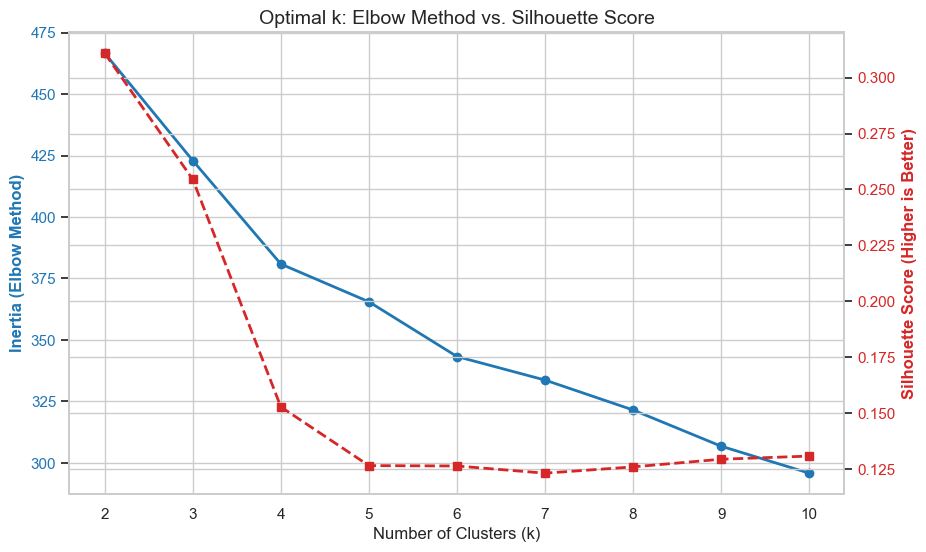

In [172]:
# Range of k to test
k_range = range(2, 11)
inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(shap_df)
    
    # 1. Inertia (for Elbow Method)
    inertia.append(kmeans.inertia_)
    
    # 2. Silhouette Score
    score = silhouette_score(shap_df, labels)
    silhouette_scores.append(score)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Elbow (Inertia)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Elbow Method)', color=color, fontweight='bold')
ax1.plot(k_range, inertia, 'o-', color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot Silhouette (on secondary y-axis)
ax2 = ax1.twinx() 
color = 'tab:red'
ax2.set_ylabel('Silhouette Score (Higher is Better)', color=color, fontweight='bold')
ax2.plot(k_range, silhouette_scores, 's--', color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Optimal k: Elbow Method vs. Silhouette Score', fontsize=14)
plt.show()

In [ ]:
inertia_df = pd.DataFrame(inertia)
# inertia_df.to_csv(r"../output/interpret_models/SHAP_value_clustering/kmeans_all_inertia.csv")
inertia_df

In [ ]:
silhouette_scores_df = pd.DataFrame(silhouette_scores)
# silhouette_scores_df.to_csv(r"../output/interpret_models/SHAP_value_clustering/kmeans_all_silhouette.csv")
silhouette_scores_df

In [298]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(shap_df)

# Attach cluster labels back to original data and SHAP data
X_analysis = X_all.copy()
X_analysis['Cluster'] = clusters
shap_df['Cluster'] = clusters

In [299]:
shap_df.head()

buildingCount  totalHeight  avgHeight  basePerimeterTotal  \
0           0.00         0.00       0.00                0.02   
1          -0.00        -0.00       0.00                0.02   
2          -0.00        -0.00       0.00                0.02   
3          -0.00        -0.00      -0.00               -0.05   
4          -0.00        -0.00      -0.00               -0.05   

   basePerimeterAvg  compactness  footprintAreaTotal  totalArea  \
0             -0.00         0.00               -0.00       0.00   
1             -0.00        -0.00                0.00      -0.01   
2             -0.00        -0.00                0.00      -0.00   
3              0.00        -0.00                0.00      -0.01   
4              0.00         0.00               -0.00      -0.02   

   avgBuildingArea   FAR  coverageRatio  roadDensity  intersectionDensity  \
0            -0.00  0.00          -0.00         0.01                -0.01   
1            -0.00 -0.00           0.00         0.01                -0.01   
2            -0.00 -0.00           0.00         0.00                -0.03   
3            -0.00 -0.01           0.00         0.01                -0.00   
4            -0.00 -0.01          -0.00         0.00                -0.00   

   poiDensity  poiDiversity   FVC  permeableRatio  maxHeight  minHeight  \
0       -0.01         -0.01 -0.01           -0.00      -0.01      -0.00   
1       -0.01         -0.01 -0.02            0.01      -0.01      -0.01   
2       -0.01         -0.01 -0.02            0.01      -0.01      -0.01   
3       -0.01         -0.01 -0.03            0.02      -0.01      -0.01   
4       -0.00         -0.00 -0.01            0.01      -0.00      -0.01   

   heightRange  heightIndex  heightDensity  heightOtherness  cornerCountTotal  \
0        -0.00         0.00           0.00            -0.01             -0.00   
1         0.00        -0.00          -0.00            -0.00             -0.00   
2        -0.00        -0.00           0.00            -0.01             -0.00   
3        -0.00         0.00           0.00            -0.00             -0.01   
4        -0.00         0.00          -0.00            -0.00             -0.01   

   basePerimeterMax  basePerimeterMin  shapeComplexity  areaVariance  \
0              0.00             -0.00            -0.00          0.00   
1             -0.00             -0.00            -0.00          0.00   
2             -0.00             -0.00            -0.00         -0.00   
3             -0.00             -0.00             0.00          0.00   
4             -0.00              0.00             0.00          0.00   

   parcelArea  largestPatchIndex  shape3DIndex  evennessIndex  cornerCountAvg  \
0       -0.00               0.00          0.00           0.00           -0.00   
1        0.01              -0.01         -0.00          -0.00           -0.01   
2       -0.00              -0.00         -0.00           0.00           -0.01   
3        0.02              -0.01         -0.00          -0.00           -0.01   
4       -0.06               0.01          0.00          -0.00           -0.00   

   buildingProximity  buildingMinDist  buildingMaxDist  buildingDistAvg  \
0               0.01            -0.00             0.00             0.00   
1              -0.00             0.00             0.00            -0.00   
2               0.00            -0.00             0.00             0.00   
3               0.00             0.00             0.00             0.00   
4              -0.01             0.00            -0.00             0.00   

   buildingDistVar   SVF  streetRatio  Cluster  
0             0.00  0.01         0.01        2  
1            -0.00 -0.01         0.00        2  
2            -0.00 -0.01         0.01        2  
3             0.00 -0.02         0.00        1  
4            -0.00  0.01         0.01        1

In [300]:
grid500['SHAP_Cluster'] = -1 
grid500.loc[X_all.index, 'SHAP_Cluster'] = clusters
grid500_clustered = grid500[grid500['SHAP_Cluster'] != -1].copy()

print(f"Mapped {len(grid500_clustered)} blocks to clusters.")

Mapped 194941 blocks to clusters.


In [301]:
grid500_clustered.describe()

Global_ID   NTL2023  NTL2023_focal  VIT202311  UHIDAY2020_07_inv  \
count  194941.00 189742.00      194941.00  194941.00          194941.00   
mean    98137.51     28.88          28.65    1414.14               0.37   
std     56862.94     19.36          17.87    1821.23               0.10   
min         0.00      0.00           0.00       0.00               0.00   
25%     49033.00     15.06          15.64     206.86               0.30   
50%     97800.00     25.85          26.01     731.14               0.38   
75%    147135.00     38.67          38.17    2003.43               0.47   
max    196769.00    465.96         348.37   68494.71               1.00   

       buildingCount  totalHeight  avgHeight  maxHeight  minHeight  \
count      194941.00    194941.00  194941.00  194941.00  194941.00   
mean           46.70       893.91      16.53      30.42       9.58   
std            50.96      1035.48       8.72      24.26       4.91   
min             0.00         0.00       0.00       0.00       0.00   
25%            12.00       144.00      12.00      12.00       6.00   
50%            35.00       559.00      16.67      27.00      12.00   
75%            65.00      1315.00      21.99      40.00      12.00   
max          1189.00     22354.50     130.50     535.00     112.00   

       heightRange  heightIndex  heightDensity  heightOtherness  \
count    194941.00    194941.00      194941.00        194941.00   
mean         20.83         0.10           0.00             0.30   
std          23.99         0.17           0.00             0.28   
min           0.00         0.00           0.00             0.00   
25%           0.00         0.02           0.00             0.00   
50%          15.00         0.04           0.00             0.28   
75%          28.00         0.09           0.01             0.43   
max         532.00         1.00           0.09             2.87   

       cornerCountTotal  basePerimeterTotal  basePerimeterAvg  \
count         194941.00           194941.00         194941.00   
mean             315.42             4959.32            112.06   
std              352.35             4245.40             60.43   
min                0.00                0.00              0.00   
25%               72.00             1417.38             83.02   
50%              222.00             4200.02            110.75   
75%              445.00             7512.92            137.30   
max             8619.00            50912.47           1689.25   

       basePerimeterMax  basePerimeterMin  shapeComplexity  compactness  \
count         194941.00         194941.00        194941.00    194941.00   
mean             347.82             22.65             4.55         0.54   
std              230.34             35.73             1.40         0.17   
min                0.00              0.00             0.00         0.00   
25%              202.45              4.35             4.57         0.53   
50%              319.04             14.07             4.82         0.57   
75%              461.66             28.38             5.08         0.62   
max             5146.21           1689.25            39.49         0.99   

       footprintAreaTotal  totalArea    areaVariance  avgBuildingArea  \
count           194941.00  194941.00       194941.00        194941.00   
mean             33192.68  216494.27    191423545.70          5437.01   
std              27474.13  210010.02   2300870309.71          7776.02   
min                  0.00       0.00            0.00             0.00   
25%               8888.17   37241.51      3519241.57          1875.57   
50%              29057.71  157756.72     20726892.83          4027.77   
75%              51784.69  347326.83     74777609.98          6726.97   
max             226640.62 3672930.95 662000000000.00        664544.83   

       parcelArea  largestPatchIndex  shape3DIndex       SVF  evennessIndex  \
count   194941.00          194941.00     194941.00 194941.00      194941.00   
mean    180006.93 

In [302]:
grid500_clustered.groupby("SHAP_Cluster").count()

Global_ID   City  NTL2023  NTL2023_focal  VIT202311  \
SHAP_Cluster                                                        
0                 57133  57133    56362          57133      57133   
1                 61911  61911    58481          61911      61911   
2                 37251  37251    36909          37251      37251   
3                 38646  38646    37990          38646      38646   

              UHIDAY2020_07_inv  buildingCount  totalHeight  avgHeight  \
SHAP_Cluster                                                             
0                         57133          57133        57133      57133   
1                         61911          61911        61911      61911   
2                         37251          37251        37251      37251   
3                         38646          38646        38646      38646   

              maxHeight  minHeight  heightRange  heightIndex  heightDensity  \
SHAP_Cluster                                                                  
0                 57133      57133        57133        57133          57133   
1                 61911      61911        61911        61911          61911   
2                 37251      37251        37251        37251          37251   
3                 38646      38646        38646        38646          38646   

              heightOtherness  cornerCountTotal  basePerimeterTotal  \
SHAP_Cluster                                                          
0                       57133             57133               57133   
1                       61911             61911               61911   
2                       37251             37251               37251   
3                       38646             38646               38646   

              basePerimeterAvg  basePerimeterMax  basePerimeterMin  \
SHAP_Cluster                                                         
0                        57133             57133             57133   
1                        61911             61911             61911   
2                        37251             37251             37251   
3                        38646             38646             38646   

              shapeComplexity  compactness  footprintAreaTotal  totalArea  \
SHAP_Cluster                                                                
0                       57133        57133               57133      57133   
1                       61911        61911               61911      61911   
2                       37251        37251               37251      37251   
3                       38646        38646               38646      38646   

              areaVariance  avgBuildingArea  parcelArea  largestPatchIndex  \
SHAP_Cluster                                                                 
0                    57133            57133       57133              57133   
1                    61911            61911       61911              61911   
2                    37251            37251       37251              37251   
3                    38646            38646       38646              38646   

              shape3DIndex    SVF  evennessIndex    FAR  coverageRatio    FVC  \
SHAP_Cluster                                                                    
0                    57133  57133          57133  57133          57133  57133   
1                    61911  61911          61911  61911          61911  61911   
2                    37251  37251          37251  37251          37251  37251   
3                    38646  38646          38646  38646          38646  38646   

              permeableRatio  poiDensity  poiDiversity  streetRatio  \
SHAP_Cluster                                                          
0                      57133       57133         57133        57133   
1                      61911       61911         61911        61911   
2                      37251       37251         37251        37251   
3                      38646       38646         38646   

In [303]:
# Create a single list of all columns you want to select
cols_to_use = ['SHAP_Cluster'] + features

# Select those columns, then group and mean
mean_values = grid500_clustered[cols_to_use].groupby('SHAP_Cluster').mean()

# Display the result
mean_values
# mean_values.to_csv(r"../output/interpret_models/SHAP_value_clustering/k5_mean_values.csv")

buildingCount  totalHeight  avgHeight  basePerimeterTotal  \
SHAP_Cluster                                                              
0                     74.04      1487.61      20.59             7892.91   
1                      7.25       105.05      10.91              734.71   
2                     49.35       817.37      16.10             4844.06   
3                     66.91      1353.72      19.94             7501.33   

              basePerimeterAvg  compactness  footprintAreaTotal  totalArea  \
SHAP_Cluster                                                                 
0                       121.03         0.57            48963.74  350317.46   
1                        88.11         0.45             5485.29   26858.86   
2                       121.23         0.60            34796.55  185188.60   
3                       128.32         0.57            52718.60  352626.49   

              avgBuildingArea  FAR  coverageRatio  roadDensity  \
SHAP_Cluster                                                     
0                     6111.57 1.40           0.20         8.85   
1                     3713.42 0.11           0.02         2.69   
2                     5731.32 0.74           0.14         2.95   
3                     6917.28 1.41           0.21         2.96   

              intersectionDensity  poiDensity  poiDiversity  FVC  \
SHAP_Cluster                                                       
0                           13.70      427.72          1.60 0.57   
1                            2.91       48.42          0.58 0.64   
2                            2.13       58.46          0.80 0.74   
3                            1.23      218.80          1.36 0.54   

              permeableRatio  maxHeight  minHeight  heightRange  heightIndex  \
SHAP_Cluster                                                                   
0                       0.81      46.11       9.31        36.81         0.04   
1                       0.94      14.55       8.70         5.85         0.21   
2                       0.92      25.76      10.27        15.49         0.05   
3                       0.84      37.11      10.73        26.37         0.04   

              heightDensity  heightOtherness  cornerCountTotal  \
SHAP_Cluster                                                     
0                      0.01             0.45            539.02   
1                      0.00             0.13             43.54   
2                      0.00             0.29            297.00   
3                      0.01             0.36            438.15   

              basePerimeterMax  basePerimeterMin  shapeComplexity  \
SHAP_Cluster                                                        
0                       450.45             13.69             5.00   
1                       174.12             37.12             3.71   
2                       370.45             19.40             4.82   
3                       452.55             15.86             4.96   

              areaVariance  parcelArea  largestPatchIndex  shape3DIndex  \
SHAP_Cluster                                                              
0             180163569.89   212295.93               0.46        485.46   
1             108716583.20   130557.96               0.43         26.63   
2             256253220.51   158316.00               0.49        133.40   
3             278077189.96   232397.27               0.68         45.69   

              evennessIndex  cornerCountAvg  buildingProximity  \
SHAP_Cluster                                                     
0                    374.66            7.53              35.12   
1                     59.89            4.63              47.44   
2                    249.54            6.15              37.91   
3                    396.79            6.60              37.49   

              buildingMinDist  buildingMaxDist  buildingDistAvg  \
SHAP_Cluster                                                      
0            

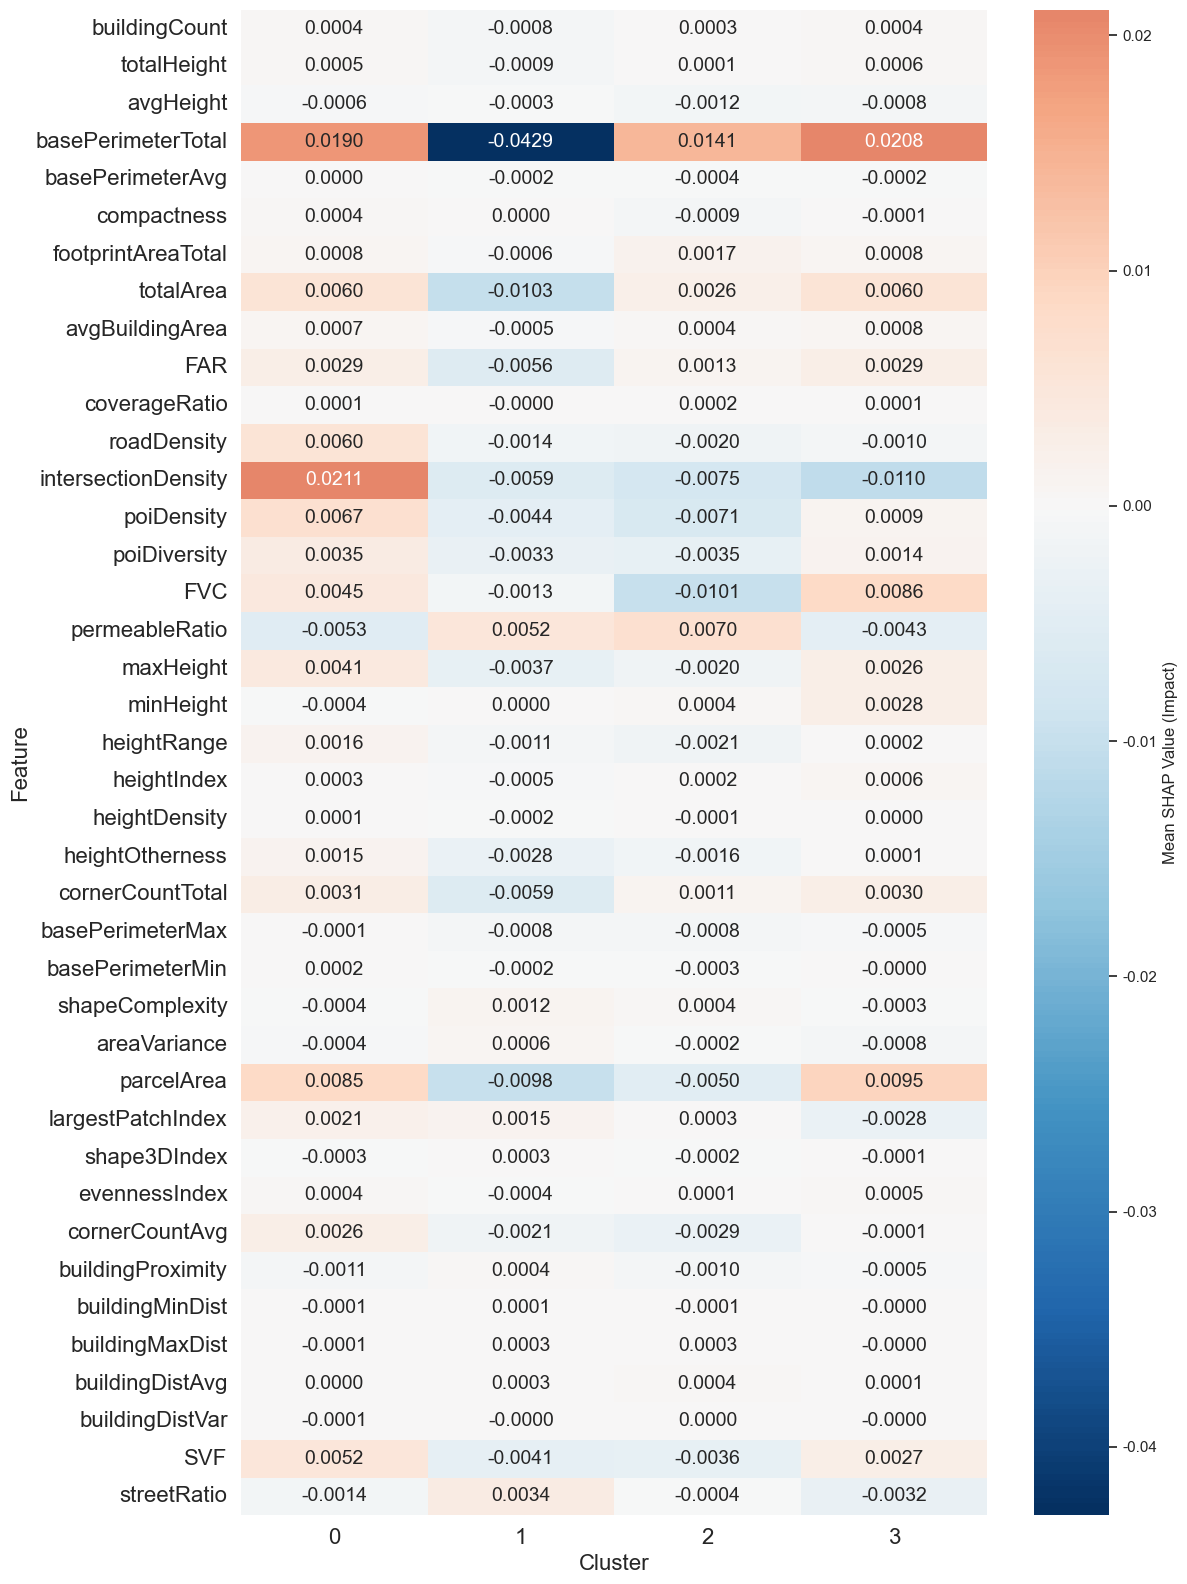

In [ ]:
# 1. Ensure you are using the FULL dataframe (no .head() or slicing)
# Recalculate the means for the full dataset
cluster_groups = shap_df.groupby('Cluster').mean().T # Transpose: Features as Rows

# 2. Dynamic Figure Height
# A good rule of thumb is 0.4 inches per feature
num_features = cluster_groups.shape[0] 
fig_height = max(6, num_features * 0.4) 

plt.figure(figsize=(12, fig_height)) # <--- This ensures enough vertical space


# 3. Plot with specific y-tick parameters
sns.heatmap(
    cluster_groups, 
    cmap="RdBu_r", 
    center=0,
    annot=True,
    fmt=".4f",       # Show 3 decimal places to see tiny non-zero values
    cbar_kws={'label': 'Mean SHAP Value (Impact)'},
    annot_kws={"size": 14},
    # ax=ax,
    # cbar_ax=cax
)

# plt.title("Urban Performance Typologies: Mean SHAP Values per Cluster", fontsize=15)
plt.xlabel("Cluster", fontsize=16)
plt.ylabel("Feature", fontsize=16)

# Force matplotlib to show every single label
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# cax.tick_params(labelsize=14) 
# cax.set_ylabel('Mean SHAP Value (Impact)', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# gdb_path = r"D:\008RA\gis_process\CN_City36\CN_City36_t1.gdb"
# layer_name = "全国网格"

# gdf = gpd.read_file(gdb_path, layer=layer_name)

# gdf_joined = gdf.merge(grid500_clustered, on="Global_ID", how="left")

# output_gdb = r"D:\008RA\gis_process\CN_City36\CN_City36_t2.gdb"
# output_layer = "全国网格_绩效t7_SHAP_cluster_k4"

# pyogrio.write_dataframe(
#     gdf_joined,
#     output_gdb,
#     layer=output_layer,
#     driver="OpenFileGDB"
# )

### 4.4.2 Cluster feature analyses

In [60]:
cluster_gdb = '../data/SHAP_cluster.gdb'
layer_name = "SHAP_cluster_k4"
shap_gdf = gpd.read_file(cluster_gdb, layer=layer_name) # set your gdb
shap_gdf.head()

Global_ID   City_x  FID_1   City_y  NTL2023  NTL2023_focal  VIT202311  \
0     0.0000  Beijing 0.0000  Beijing   6.1850         7.0300  1649.8571   
1     1.0000  Beijing 1.0000  Beijing   5.7400         7.2261   155.8571   
2     2.0000  Beijing 2.0000  Beijing  11.3200        13.6167    57.1429   
3     3.0000  Beijing 3.0000  Beijing  11.7300        14.3617   243.5714   
4     4.0000  Beijing 4.0000  Beijing   8.4500         9.1900     0.0000   

   UHIDAY2020_07_inv  buildingCount  totalHeight  avgHeight  maxHeight  \
0             0.4728        31.0000      93.0000     3.0000     3.0000   
1             0.4728        29.0000      87.0000     3.0000     3.0000   
2             0.4728        22.0000      66.0000     3.0000     3.0000   
3             0.4728         8.0000      24.0000     3.0000     3.0000   
4             0.4728         0.0000       0.0000     0.0000     0.0000   

   minHeight  heightRange  heightIndex  heightDensity  heightOtherness  \
0     3.0000       0.0000       0.0323         0.0004           0.0000   
1     3.0000       0.0000       0.0345         0.0003           0.0000   
2     3.0000       0.0000       0.0455         0.0003           0.0000   
3     3.0000       0.0000       0.1250         0.0001           0.0000   
4     0.0000       0.0000       0.0000         0.0000           0.0000   

   cornerCountTotal  basePerimeterTotal  basePerimeterAvg  basePerimeterMax  \
0          180.0000           6500.9830          209.7091          831.6324   
1          149.0000           3810.3930          131.3929          272.1380   
2          117.0000           3645.3976          165.6999          668.2643   
3           42.0000           1147.5982          143.4498          283.0113   
4            0.0000              0.0000            0.0000            0.0000   

   basePerimeterMin  shapeComplexity  compactness  footprintAreaTotal  \
0           32.5533           5.0701       0.5614          88704.5751   
1           15.3292           5.1700       0.6206          33119.4905   
2           28.7300           4.9243       0.5589          51092.8628   
3           75.6611           5.7024       0.5969           8534.6141   
4            0.0000           0.0000       0.0000              0.0000   

   totalArea  areaVariance  avgBuildingArea  parcelArea  largestPatchIndex  \
0 88704.5751 50961857.7000        2861.4379 132998.2511             0.4670   
1 33119.4905  1261729.8840        1142.0514 196625.2176             0.6683   
2 51092.8628 30358745.8300        2322.4029 132197.3125             0.5288   
3  8534.6141   958399.8878        1066.8268 205685.3683             0.8227   
4     0.0000        0.0000           0.0000     99.1487             0.0004   

   shape3DIndex    SVF  evennessIndex    FAR  coverageRatio    FVC  \
0        0.0082 0.8024       234.6035 0.3548         0.3548 0.8366   
1        0.2644 0.8906        35.6626 0.1325         0.1325 0.8570   
2        0.0134 0.8982       151.4966 0.2044         0.2044 0.8818   
3        0.0179 0.9475        15.5408 0.0341         0.0341 0.9335   
4        0.0000 0.9777         0.0000 0.0000         0.0000 0.8153   

   permeableRatio  poiDensity  poiDiversity  streetRatio  roadDensity  \
0          0.8948      4.0000        0.0000       0.1994       5.0000   
1          0.9383     12.0000        0.6365       0.1994       7.0000   
2          0.9257      0.0000        0.0000       0.1994       1.0000   
3          0.9785      0.0000        0.0000       0.1994       3.0000   
4          0.9844     16.0000        0.6931       0.0000       1.0000   

   intersectionDensity  cornerCountAvg  buildingProximity  buildingMinDist  \
0               1.0000          5.8065            52.5611          14.9887   
1               1.0000          5.1379            34.2211           6.8159   
2               0.0000          5.3182            47.9015          17.3445   
3               1.0000          5.2500            35.9269          13.4894   
4               1.0000 

Summary statistics of performance scores by SHAP-based cluster:
- The table reports the number of observations (block count), mean, standard deviation, minimum, first quartile (Q1), median, third quartile (Q3), and maximum for each cluster.

In [63]:
cluster_features = shap_gdf.groupby('SHAP_Cluster').mean(numeric_only=True)

In [64]:
cluster_perf_stats = (
    shap_gdf
    .groupby('SHAP_Cluster')['performance_score']
    .agg(
        count='count',
        mean='mean',
        std='std',
        min='min',
        q25=lambda x: x.quantile(0.25),
        median='median',
        q75=lambda x: x.quantile(0.75),
        max='max'
    )
)

# cluster_perf_stats.to_csv("cluster_perf_stats.csv")
cluster_perf_stats

count   mean    std    min    q25  median    q75    max
SHAP_Cluster                                                         
0.0000        57133 0.7530 0.0876 0.2262 0.6939  0.7561 0.8138 0.9998
1.0000        37251 0.6344 0.1070 0.0527 0.5726  0.6439 0.7081 0.9954
2.0000        63515 0.6170 0.1547 0.0125 0.5296  0.6431 0.7276 1.0000
3.0000        37042 0.6125 0.1236 0.0000 0.5400  0.6241 0.6965 0.9987

In [ ]:
plot_df = cluster_features.reset_index()

if 'SHAP_Cluster' not in plot_df.columns:
    plot_df = plot_df.rename(columns={'index': 'SHAP_Cluster'})

features = [
    'buildingCount', 'totalHeight', 'avgHeight', 'basePerimeterTotal',
    'basePerimeterAvg', 'compactness', 'footprintAreaTotal', 'totalArea',
    'avgBuildingArea', 'FAR', 'coverageRatio',
    'roadDensity', 'intersectionDensity', 'poiDensity', 'poiDiversity',
    'FVC', 'permeableRatio', 'maxHeight', 'minHeight', 'heightRange', 'heightIndex',
    'heightDensity', 'heightOtherness', 'cornerCountTotal', 'basePerimeterMax',
    'basePerimeterMin', 'shapeComplexity', 'areaVariance', 'parcelArea',
    'largestPatchIndex', 'shape3DIndex', 'evennessIndex', 'cornerCountAvg',
    'buildingProximity', 'buildingMinDist', 'buildingMaxDist',
    'buildingDistAvg', 'buildingDistVar', 'SVF', 'streetRatio'
]

Urban form characteristics across SHAP-based clusters:
- Bar charts show the mean values of 40 urban form indicators for each SHAP-based cluster (Clusters 0-3). Differences across clusters highlight distinct urban form configurations underlying similar or divergent PPF-based performance outcomes.

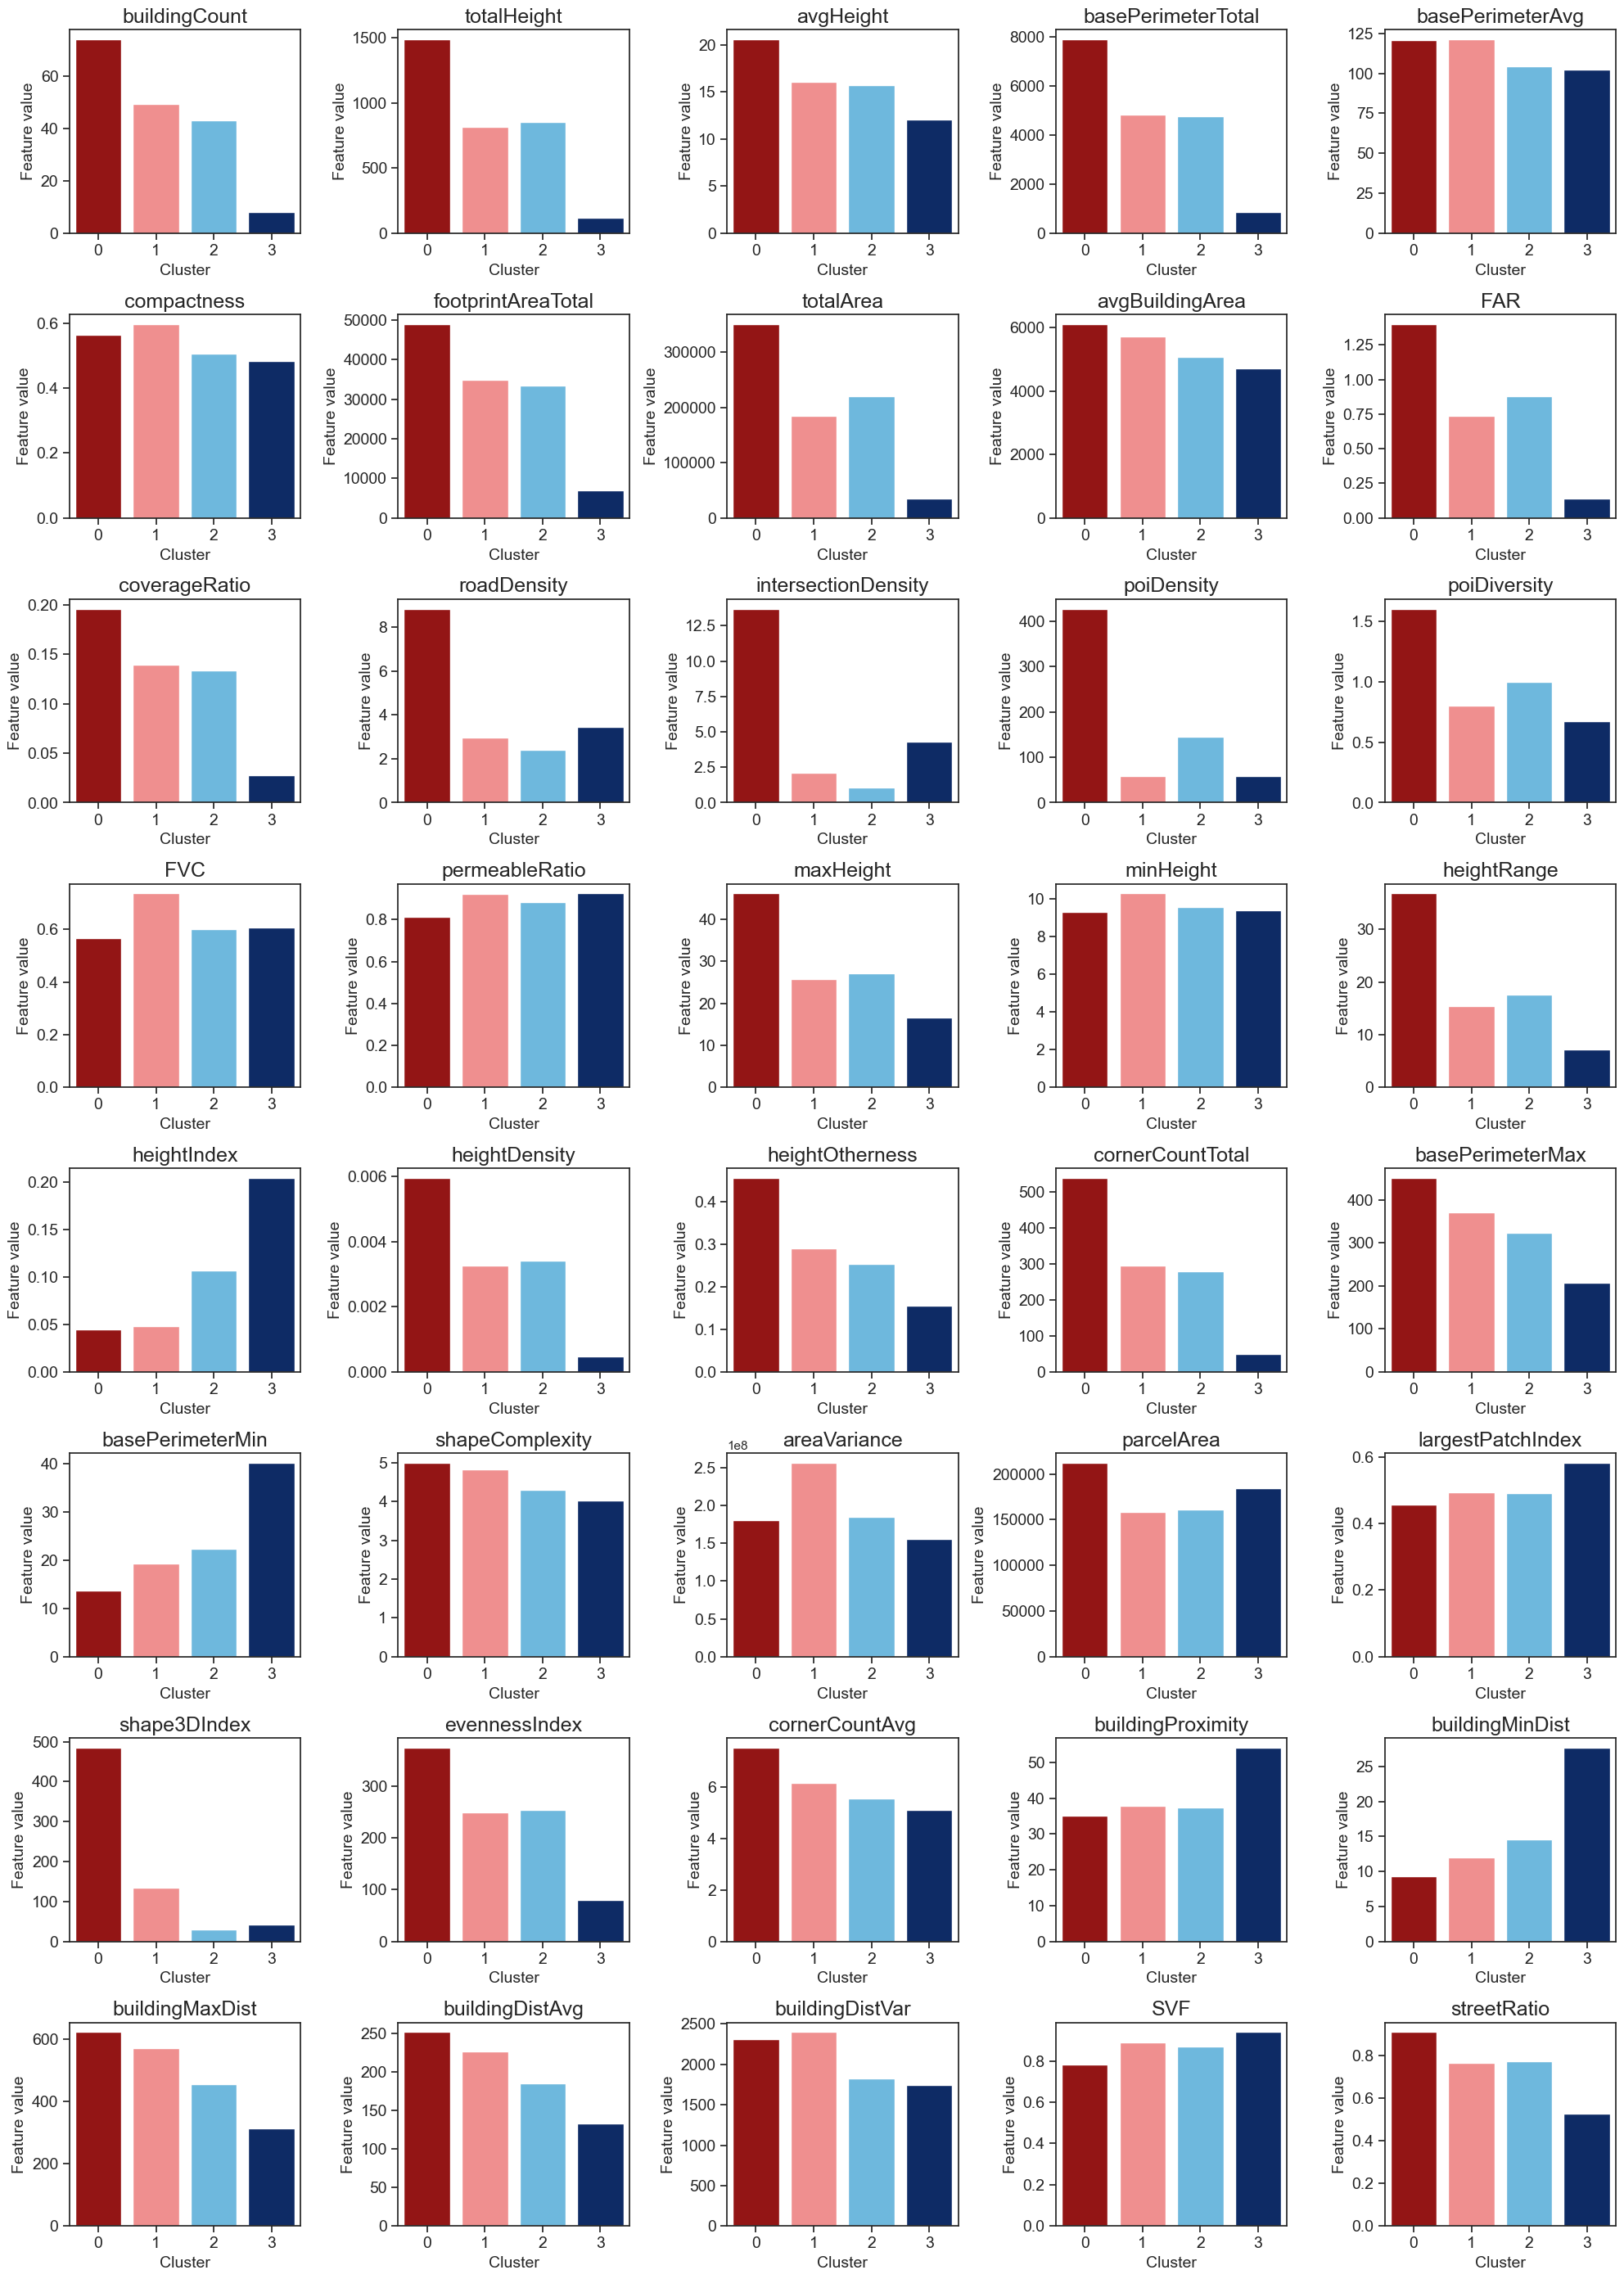

In [ ]:
plot_df['SHAP_Cluster'] = plot_df['SHAP_Cluster'].astype(int)
cluster_colors = {
    "0": "#A80000",
    "1": "#FF7F7F",
    "2": "#5BBEF0",
    "3": "#002673"
}

cols = 5
rows = 8 
fig, axes = plt.subplots(rows, cols, figsize=(20, 3.5 * rows))
axes = axes.flatten()

for i, feature_name in enumerate(features):
    ax = axes[i]
    
    if feature_name in plot_df.columns:
        sns.barplot(
            data=plot_df, 
            x='SHAP_Cluster', 
            y=feature_name, 
            ax=ax,
            palette=cluster_colors,
            errorbar='sd', 
            capsize=0.1
        )
        
        ax.set_title(feature_name, fontsize=18)
        ax.set_xlabel('Cluster', fontsize=14) 
        ax.set_ylabel('Feature value', fontsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        
    #     if i < (rows - 1) * cols:
    #         ax.set_xticklabels([])
    # else:
    #     ax.axis('off')

for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

# plt.suptitle("Mean Urban Form Characteristics by Cluster", fontsize=22, y=1.005)
plt.tight_layout()
plt.show()

### 4.4.3 Case study: Hangzhou

In [65]:
hz = shap_gdf[shap_gdf['City_x'] == "Hangzhou"]
hz.shape

(7565, 58)

In [66]:
shap_cluster_hz = hz.groupby('SHAP_Cluster').mean(numeric_only=True)
shap_cluster_hz

Global_ID     FID_1  NTL2023  NTL2023_focal  VIT202311  \
SHAP_Cluster                                                           
0.0000       63760.7555 4049.7555  41.1122        40.0936  2437.0895   
1.0000       63052.0253 3341.0253  18.9314        18.8125   726.6188   
2.0000       63269.1406 3558.1406  25.5395        25.2946   949.9640   
3.0000       64051.8353 4340.8353  30.0607        30.1878   426.0811   

              UHIDAY2020_07_inv  buildingCount  totalHeight  avgHeight  \
SHAP_Cluster                                                             
0.0000                   0.3116        64.7066    1481.0624    22.6495   
1.0000                   0.3867        58.0243    1063.9216    17.5984   
2.0000                   0.3682        38.9427     785.6328    16.6094   
3.0000                   0.3887        11.1094     181.4041    14.8916   

              maxHeight  minHeight  heightRange  heightIndex  heightDensity  \
SHAP_Cluster                                                                  
0.0000          45.7963    11.2632      34.5331       0.0427         0.0059   
1.0000          26.1305    11.8735      14.2569       0.0369         0.0043   
2.0000          26.4795    11.0812      15.3983       0.1199         0.0031   
3.0000          22.0888    11.3906      10.6982       0.1766         0.0007   

              heightOtherness  cornerCountTotal  basePerimeterTotal  \
SHAP_Cluster                                                          
0.0000                 0.3892          467.7706           6924.1193   
1.0000                 0.2333          328.8557           5092.3388   
2.0000                 0.2282          245.9916           4087.6756   
3.0000                 0.1866           69.1274           1091.5210   

              basePerimeterAvg  basePerimeterMax  basePerimeterMin  \
SHAP_Cluster                                                         
0.0000                117.9266          449.1327           14.4554   
1.0000                105.9241          341.3573           17.2180   
2.0000                 98.6394          306.6877           22.8616   
3.0000                101.9770          232.0446           33.5250   

              shapeComplexity  compactness  footprintAreaTotal   totalArea  \
SHAP_Cluster                                                                 
0.0000                 4.9528       0.5764          43312.5113 333319.3708   
1.0000                 4.7078       0.6233          33839.7244 189167.7789   
2.0000                 4.4991       0.5531          28415.5682 180515.4489   
3.0000                 4.4957       0.5531           7924.9959  42223.9096   

               areaVariance  avgBuildingArea  parcelArea  largestPatchIndex  \
SHAP_Cluster                                                                  
0.0000       163723598.3094        6189.9929 206353.2000             0.4193   
1.0000       219045933.7488        4807.5637 127589.9771             0.3798   
2.0000       142040847.4783        4323.1208 134827.7894             0.3824   
3.0000       172258904.4948        4579.7072 143889.5364             0.4331   

              shape3DIndex    SVF  evennessIndex    FAR  coverageRatio    FVC  \
SHAP_Cluster                                                                    
0.0000             12.7970 0.7347       350.3637 1.3333         0.1733 0.5999   
1.0000              3.3991 0.8276       229.1706 0.7567         0.1354 0.7273   
2.0000              2.1522 0.8170       210.4944 0.7221         0.1137 0.6560   
3.0000              1.0779 0.9014        95.9877 0.1689         0.0317 0.6467   

              permeableRatio  poiDensity  poiDiversity  streetRatio  \
SHAP_Cluster                                                          
0.0000                0.8614    381.7838        1.5833       1.0565   
1.0000                0.9405     66.8135        0.9050       0.8683   
2.0000                0.9291    147.8769        1.0864       0.8163   
3.0000                0.946

In [ ]:
# shap_cluster_hz.to_csv(r'../output/interpret_models/SHAP_value_clustering/k4_hangzhou_mean.csv')